In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import operator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import re
import sys
import pickle
from tqdm import tqdm
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/train_cs.csv')
print(df1.columns)

Index(['UserID', 'YOB', 'Gender', 'Income', 'HouseholdStatus',
       'EducationLevel', 'Party', 'Happy', 'Q124742', 'Q124122',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=110)


In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/test_cs.csv')
print(df2.columns)

Index(['UserID', 'YOB', 'Gender', 'Income', 'HouseholdStatus',
       'EducationLevel', 'Party', 'Q124742', 'Q124122', 'Q123464',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=109)


In [ ]:
# frequency of distinct values under class lable in trainset
print(df1.Happy.value_counts()) 
#print(df2.Happy.value_counts())

1    2604
0    2015
Name: Happy, dtype: int64


  Nearly 56% of the observations are positive and the remaining are negative. Both are almost equally distributed. So dataset need not be balanced

In [ ]:
# gives % of null values under each feature both in train and test set
print("train set\n",df1.isnull().sum() * 100 / len(df1))
print("test set\n",df2.isnull().sum() * 100 / len(df1))

train set
 UserID              0.000000
YOB                14.808400
Gender             11.625893
Income             26.304395
HouseholdStatus    17.319766
                     ...    
Q98059             27.430180
Q98078             32.842607
Q98197             31.132280
Q96024             31.586924
votes               0.000000
Length: 110, dtype: float64
test set
 UserID              0.000000
YOB                 6.798008
Gender              5.282529
Income             11.387746
HouseholdStatus     7.620697
                     ...    
Q98059             11.084650
Q98078             13.379519
Q98197             12.535181
Q96024             13.098073
votes               0.000000
Length: 109, dtype: float64


Initially each feature is verified for 85%+ missing values. There are no such features under this category.

Features with missing values between 5-20% are replaced with either mean/median/mode. Such features are ['YOB', 'Gender', 'HouseholdStatus', 'Party']. 'YOB' contains numerical features and it also contains outliers (this has been identified through IQR computation).As per the number of missing values median has been chosen to fill the missing values. In the remaining categorical data null value are replaced with most probable value. 

Features with missing values between 20-85% are imputed with machine learning model.

In [ ]:
# there are no features with 85%+ missing values ( to drop those columns)
#trainset
for i in (df1.columns):
    if(df1[i].isnull().sum()*100/len(df1)) > 85 :
        print(i)
#testset
for i in (df2.columns):
    if(df2[i].isnull().sum()*100/len(df2)) > 85 :
        print(i)

In [ ]:
#features with missing values between 5-20% missing (mean/median is to be used to fill NAN values)
features_mean = []
for i in (df1.columns):
    if(df1[i].isnull().sum()*100/len(df1)) >=5 and (df1[i].isnull().sum()*100/len(df1))<=20:
        features_mean.append(i)
print(features_mean)

features_mean_test = []
for i in (df2.columns):
    if(df2[i].isnull().sum()*100/len(df2)) >=5 and (df2[i].isnull().sum()*100/len(df2))<=20:
        features_mean_test.append(i)
features_mean_test

['YOB', 'Gender', 'HouseholdStatus', 'Party']


['YOB', 'Gender', 'HouseholdStatus', 'Party']

In [ ]:
#Features with missing values between 20-85% (model based imputatoin is to be used)
#train set
features_impu = []
for i in (df1.columns):
    if(df1[i].isnull().sum()*100/len(df1)) >20 and (df1[i].isnull().sum()*100/len(df1))<=85:
        features_impu.append(i)
print('train',len(features_impu))

#test set
features_impu_test = []
for i in (df2.columns):
    if(df2[i].isnull().sum()*100/len(df2)) >20 and (df2[i].isnull().sum()*100/len(df2))<=85:
        features_impu_test.append(i)
print('test',len(features_impu_test))

train 103
test 103


In [ ]:
# for analysis USerID is not required. So we can drop that
df1.drop(['UserID'], axis = 1, inplace = True)
df2.drop(['UserID'], axis = 1, inplace = True)

In [ ]:
print('train',len(df1))
print('test',len(df2))

train 4619
test 1980


In both train and test most of the field values are missing. There rare different ways to handle the missing values.
    1.Drop missing values/columns/rows
    2.Imputation

1.This is the simplest way to handle the missing values, but not the optimal way. If the dataset set is very large and very few of the observations are having missing fields then we can go with this option(this is in case of rows). In case of columns if more than 60% of the data is missing and if that feature is insignificant then we can eliminate the feature. But you may loose the potential information. So the better approach is imputation.

2.when compared to the previous approach this is slightly better one. In this we can deal with the data in different ways.
    a)Missing values can be replaced with any constant value like 0 or 1 or -1. Here in the given dataset almost all the features are categorical. if the feature is binary categorical then they can be replaced with 0 or 1 before applying machine learning model ans NAN values can be replaced with -1.
    b)Feature's NAN values can be replaced with mean,meadian or mode values of that particular column. 'Income' NAN values can be replaced with mean of the people's income in that age group.
    c)Any predicitve model(linear regression which can be applied on numerical feture) can be used to replace the missing values. Heatmap can also be used to find the correlation between the features. If 'Income' is highly correlated with 'YOB' and 'EducationLEvel' then these two can be used to fill the missing values of 'Income'.
    d)Multiple Imputation: it reduces uncertainty about missing values by calculating several different options. One of the most used method for imputaion is MICE.
    

In [ ]:
# convert both train and test 'YOB' to age
df1['YOB'] = 2014 - df1['YOB'] 
df2['YOB'] = 2014 - df2['YOB'] 

In [ ]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='Happy', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    # total number of people under each distinct value of the feature
    p1 = plt.bar(ind, data[col3].values)
    # toatl number of people who are happy under each distinct value of the feature
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Happy')
    plt.title('Number of people happy vs not happy')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'Happy'))
    plt.show()

In [ ]:
def univariate_barplots(data, col1, col2='Happy', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    
    # taking unique values from col1 and calculating total number of +ve labels under each
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    
    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(20))
    #print("*"*50)
    #print(temp.tail(20))

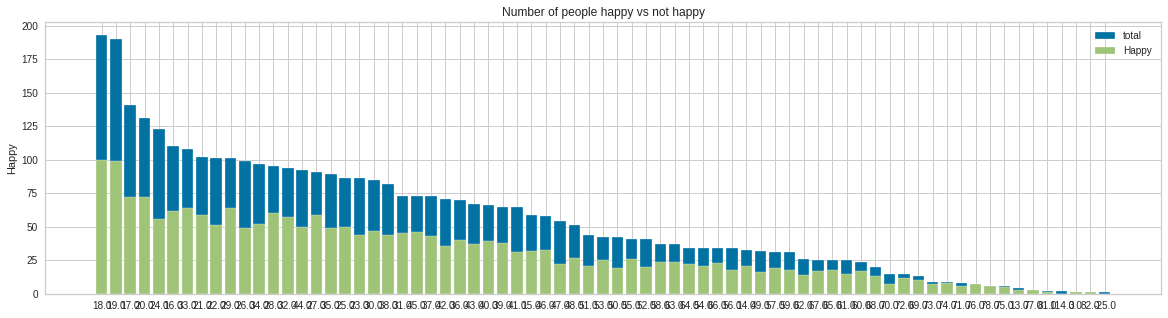

     YOB  Happy  total       Avg
7   18.0    100    193  0.518135
8   19.0     99    190  0.521053
6   17.0     72    141  0.510638
9   20.0     72    131  0.549618
13  24.0     56    123  0.455285
5   16.0     62    110  0.563636
22  33.0     64    108  0.592593
10  21.0     59    102  0.578431
11  22.0     51    101  0.504950
18  29.0     64    101  0.633663
15  26.0     49     99  0.494949
23  34.0     52     97  0.536082
17  28.0     60     95  0.631579
21  32.0     57     94  0.606383
33  44.0     50     92  0.543478
16  27.0     59     91  0.648352
24  35.0     49     89  0.550562
14  25.0     50     86  0.581395
12  23.0     44     86  0.511628
19  30.0     47     85  0.552941


In [ ]:
univariate_barplots(df1,'YOB','Happy',False)

Most of the people who have answered the questions are young and the people whose age is above 70 are more happy when compared to young. So while imputing the missed values we can replace it with mode or most probable value. However 5-20% of the values are missing under 'YOB'. So median is chosen to fill the missing values.

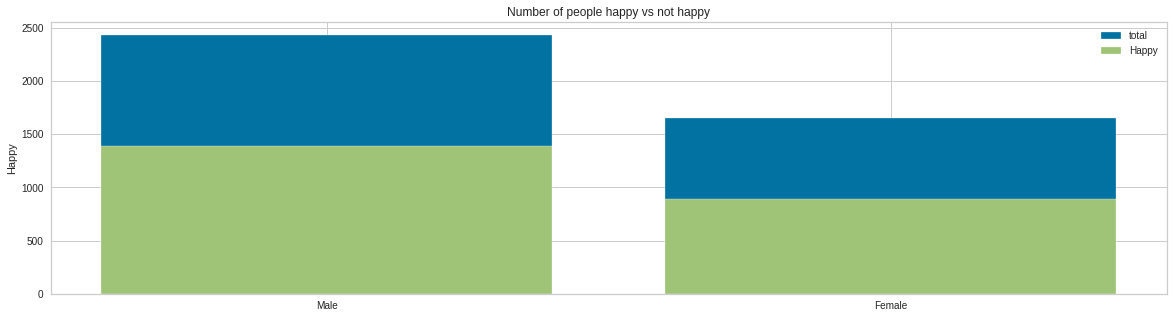

   Gender  Happy  total       Avg
1    Male   1387   2432  0.570312
0  Female    895   1650  0.542424


In [ ]:
univariate_barplots(df1,'Gender','Happy',False)

This gender feature is not much influencing the class label 'Happy'. Male count is more when compared to female count. However the ratio of happiness is almost same. 5-20% data is missing under this feature. As  this is a categorical data, so most probable(median) has been chosen to fill the missing values.

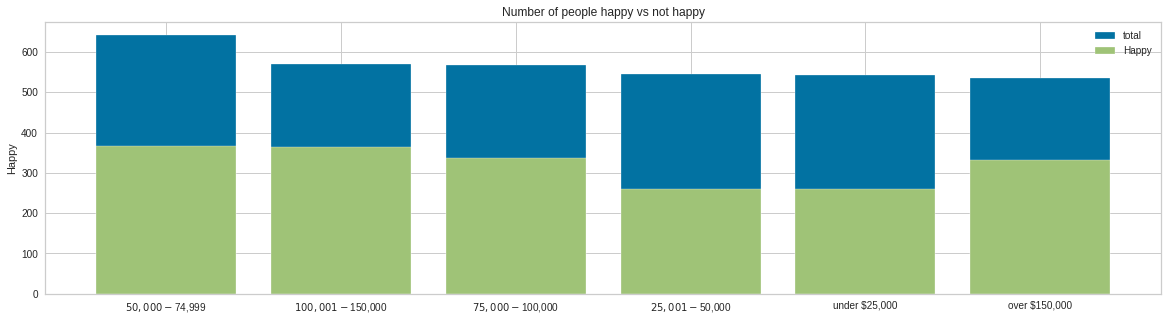

                Income  Happy  total       Avg
2    $50,000 - $74,999    366    642  0.570093
0  $100,001 - $150,000    364    571  0.637478
3   $75,000 - $100,000    337    567  0.594356
1    $25,001 - $50,000    260    545  0.477064
5        under $25,000    260    543  0.478821
4        over $150,000    333    536  0.621269


In [ ]:
univariate_barplots(df1,'Income','Happy',False)

'Income' feature is much influencing the class label 'Happy'. People 
whose income is high are more happier when comared to others. So considered this as a relevant feature.IT is an ordinal categorical data and the % of missing data is between 20-85%. So ML imputation is adopted to fill the missing values.

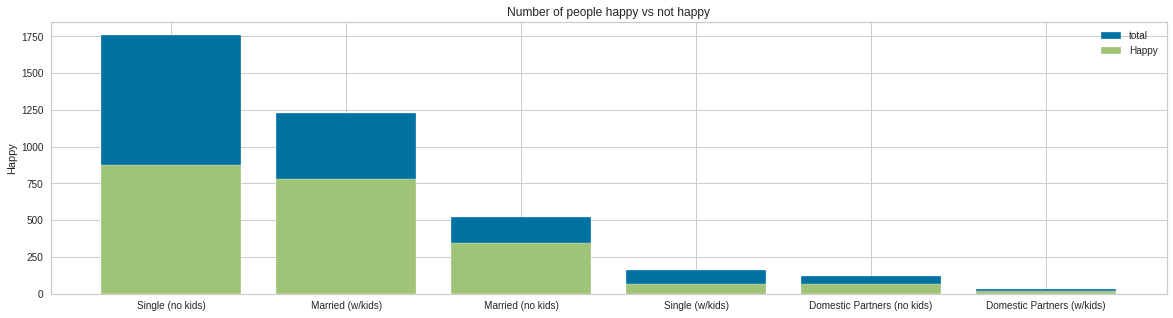

               HouseholdStatus  Happy  total       Avg
4             Single (no kids)    873   1760  0.496023
3             Married (w/kids)    783   1226  0.638662
2            Married (no kids)    346    522  0.662835
5              Single (w/kids)     69    159  0.433962
0  Domestic Partners (no kids)     70    118  0.593220
1   Domestic Partners (w/kids)     16     34  0.470588


In [ ]:
univariate_barplots(df1,'HouseholdStatus','Happy',False)

Single(no kids), single(w/kids) and Domestic Partners(w/kids) are less happier than remaining categories. This is also one important ordinal categorical feature while analyzing the data. % of missing values is between 5-25%. So null values are replaced with most probable value (mode)

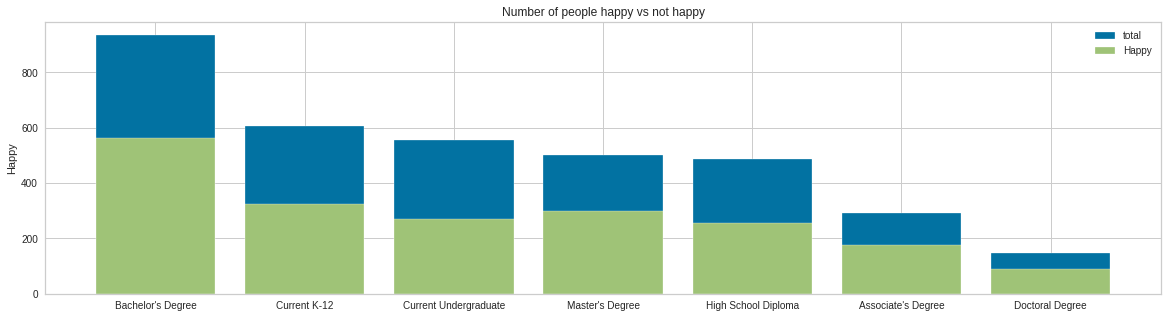

          EducationLevel  Happy  total       Avg
1      Bachelor's Degree    561    935  0.600000
2           Current K-12    326    607  0.537068
3  Current Undergraduate    270    557  0.484740
6        Master's Degree    298    503  0.592445
5    High School Diploma    255    487  0.523614
0     Associate's Degree    176    291  0.604811
4        Doctoral Degree     90    148  0.608108


In [ ]:
univariate_barplots(df1,'EducationLevel','Happy',False)

People whose education level is high are more happier than remaining. Considered this as an important feature so kept this feature to analyze the data and % of missing data is between 20-85%. This is ordinal categorical data and chosen ML imputing method to fill the data.

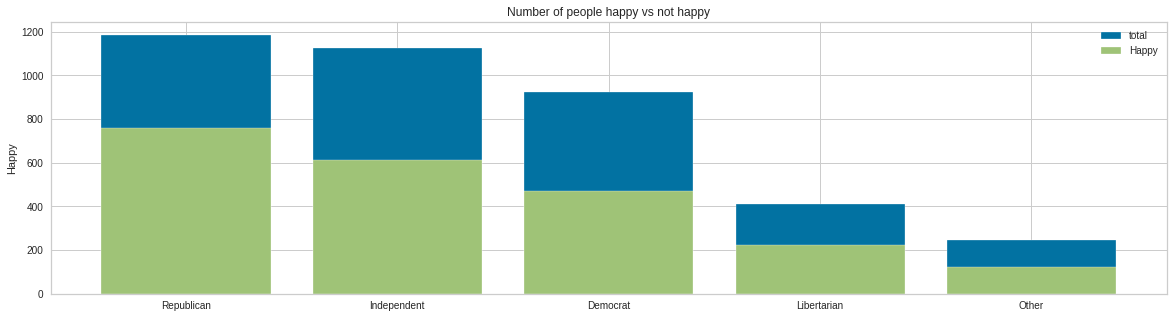

         Party  Happy  total       Avg
4   Republican    758   1185  0.639662
1  Independent    612   1126  0.543517
0     Democrat    471    926  0.508639
2  Libertarian    224    409  0.547677
3        Other    124    245  0.506122


In [ ]:
univariate_barplots(df1,'Party','Happy',False)

Republican's are happier than others. for predicitng the class lable for the new observation this feature may play an important role. so considered this label. For imputing missing values median value has been used.

 Now all the text data is to be encoded for further EDA

when giving dataset as input to ML algorithm, it should not contain any string
data. So data is to be encoded. In the given dataset, 'UserID' is the unique ID of each observation, except 'YOB','votes', remaining all are categorical.  Where as income and EducationLevel are ordinal. So while assigning indices to the feature categories order is to be considered.

Following is the code for that

In [ ]:
df1 = df1.replace({'HouseholdStatus': {'Married (w/kids)' :3, 'Single (no kids)':0, 'Married (no kids)':2,'Domestic Partners (no kids)':4,'Domestic Partners (w/kids)':5, 'Single (w/kids)':1}})
df2 = df2.replace({'HouseholdStatus': {'Married (w/kids)' :3, 'Single (no kids)':0, 'Married (no kids)':2,'Domestic Partners (no kids)':4,'Domestic Partners (w/kids)':5, 'Single (w/kids)':1}})

In [ ]:
df1 = df1.replace({'EducationLevel': {'Master\'s Degree':3, 'High School Diploma':0, 'Current K-12':1,'Current Undergraduate':2,'Bachelor\'s Degree':2, 'Associate\'s Degree':3,'Doctoral Degree':4}})
df2 = df2.replace({'EducationLevel': {'Master\'s Degree':3, 'High School Diploma':0, 'Current K-12':1,'Current Undergraduate':2,'Bachelor\'s Degree':2, 'Associate\'s Degree':3,'Doctoral Degree':4}})

In [ ]:
df1['Income'] = df1.Income.map({'$25,001 - $50,000':1,'over $150,000':5,'$75,000 - $100,000':3,'$50,000 - $74,999':2,'under $25,000':0,'$100,001 - $150,000':4})
df2['Income'] = df2.Income.map({'$25,001 - $50,000':1,'over $150,000':5,'$75,000 - $100,000':3,'$50,000 - $74,999':2,'under $25,000':0,'$100,001 - $150,000':4})

Income and EducationLevel are ordinal features.

In [ ]:
df1['Party'] = df1.Party.map({'Independent':0,'Democrat':1,'Republican':2,'Libertarian':3,'Other':4})
df2['Party'] = df2.Party.map({'Independent':0,'Democrat':1,'Republican':2,'Libertarian':3,'Other':4})

In [ ]:
df1['Gender'] = df1.Gender.map({'Male':0, 'Female':1})
df2['Gender'] = df2.Gender.map({'Male':0, 'Female':1})

In [ ]:
# take all the columns which are starting with 'Q'
filter_col = [col for col in df1 if col.startswith('Q')]
for col in filter_col: 
    # converted yes/no or other feature string values to binary 0 or 1
    #print(col) from the given pdf file possible answers for the questions have been collected
    d = {'No': 0, 'Yes': 1, 'Only-child':0, 'Check!':0,'Nope':1,'Optimist':1,'Pessimist':0,'Mom':0,'Dad':1,'Rent':0,'Own':1, 'Yay people!':0,'Grrr people':1,'Online':0,'In-person':1,'Yes!':1,'Umm...':0,'Socialize':1,'Space':0,'Cautious':1,'Risk-friendly':0,'Mac':1,'PC':0,'Supportive':1,'Demanding':0,'Tunes':0,'Talk':1,'People':0,'Technology':1,'TMI':0,'Mysterious':1,'Start':0,'End':1,'Circumstances':0,'Me':1,'A.M.':0,'P.M.':1,'Happy':0,'Right':1,'Hot headed':0,'Cool headed':1,'Standard hours':0,'Odd hours':1,'Idealist':0,'Pragmatist':1,'Giving':0,'Receiving':1,'Study first':0,'Try first':1,'Science':0,'Art':1,'Public':0,'Private':1}
    df1[col] = df1[col].map(d).fillna(df1[col])
    df2[col] = df2[col].map(d).fillna(df2[col])

In [ ]:
df1
# Finally dataset is having only numerical values and NAN .
#latter these NAN values can be either ignored or replaced with mean/neadian.mode or imputed
# base on the %of missing values

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,76.0,0.0,NaN,3.0,NaN,0.0,1,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0,86
1,29.0,1.0,1.0,0.0,3.0,1.0,1,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,66
2,51.0,0.0,5.0,3.0,NaN,NaN,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101
3,17.0,0.0,3.0,0.0,0.0,2.0,1,NaN,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98
4,18.0,0.0,2.0,0.0,1.0,NaN,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
4615,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
4616,16.0,1.0,5.0,0.0,1.0,2.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
4617,NaN,1.0,NaN,NaN,NaN,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


Outliers influence the existing data, and thus they should be handled before 
imputing missing values.

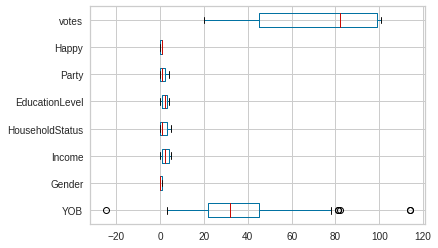

In [ ]:
df1[['YOB','Gender', 'Income', 'HouseholdStatus','EducationLevel', 'Party', 'Happy','votes',]].plot.box(vert = False, 
                                                                                                        grid = True)

Here we can observe that YOB is containing outliers

In [ ]:
df1.loc[df1.YOB >= 80, 'YOB']# YOB > 80

1426    114.0
1763     81.0
2128     81.0
3393     82.0
3986    114.0
Name: YOB, dtype: float64

Identifying Outlier:
These can be identified by using IQR 

In [ ]:
#Computing 25th 50th and 75th percentile of each column in df1 for identifying outliers.
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

YOB                23.0
Gender              1.0
Income              3.0
HouseholdStatus     3.0
EducationLevel      2.0
                   ... 
Q98059              0.0
Q98078              1.0
Q98197              1.0
Q96024              1.0
votes              54.0
Length: 109, dtype: float64


In [ ]:
df1_TF = (df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))
print(df1_TF[df1_TF== True].count().sum())
print(df1_TF)

df2_TF = (df2 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))
print(df2_TF[df2_TF== True].count().sum())
print(df2_TF)



10164
        YOB  Gender  Income  HouseholdStatus  ...  Q98078  Q98197  Q96024  votes
0     False   False   False            False  ...   False   False   False  False
1     False   False   False            False  ...   False   False   False  False
2     False   False   False            False  ...   False   False   False  False
3     False   False   False            False  ...   False   False   False  False
4     False   False   False            False  ...   False   False   False  False
...     ...     ...     ...              ...  ...     ...     ...     ...    ...
4614  False   False   False            False  ...   False   False   False  False
4615  False   False   False            False  ...   False   False   False  False
4616  False   False   False            False  ...   False   False   False  False
4617  False   False   False            False  ...   False   False   False  False
4618  False   False   False            False  ...   False   False   False  False

[4619 rows x 109 colu

altogther there are 10155 outliers. there are two ways to deal with these outliers: first one is dropping and the second one is correcting. Dropping the outliers may lead to loss of information.So, outliers ar to be corrected. This can be done either by mean or mode.

In [ ]:
df1.describe()

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
count,3935.000000,4082.000000,3404.000000,3819.000000,3528.000000,3891.000000,4619.000000,2056.000000,3006.000000,3164.000000,3095.000000,3286.000000,3408.000000,3418.000000,3389.000000,3539.000000,3506.000000,3444.000000,3485.000000,3400.000000,3394.000000,3343.000000,3282.000000,3431.000000,3297.000000,3412.000000,3521.000000,3429.000000,3600.000000,3527.000000,3039.000000,3330.000000,3379.000000,3190.000000,3209.000000,3281.000000,3174.000000,3207.000000,3402.0000,3364.000000,...,3283.000000,3028.000000,3220.000000,3250.000000,3261.000000,3244.000000,3317.000000,3309.000000,3300.000000,3298.000000,3239.000000,3190.000000,3285.000000,3181.000000,3390.000000,3367.000000,3313.000000,3187.000000,3178.000000,3304.000000,3254.000000,3290.000000,3238.000000,3134.000000,3251.000000,3421.000000,3278.000000,3270.000000,3201.000000,3372.000000,3264.000000,3331.000000,3309.000000,3143.000000,3171.000000,3352.000000,3102.000000,3181.000000,3160.000000,4619.000000
mean,34.864803,0.404214,2.495300,1.446190,1.860828,1.414289,0.563758,0.367704,0.589820,0.062579,0.513409,0.385575,0.575998,0.165886,0.262614,0.735519,0.133771,0.555749,0.551506,0.456765,0.920448,0.317380,0.418038,0.471583,0.595693,0.487691,0.417779,0.238554,0.630278,0.408279,0.563343,0.281682,0.458124,0.643887,0.404799,0.338921,0.285444,0.668538,0.8301,0.376338,...,0.121535,0.290621,0.327329,0.689231,0.392518,0.547472,0.868556,0.828649,0.538788,0.715888,0.271689,0.472100,0.475495,0.459290,0.551327,0.509356,0.464232,0.360527,0.365639,0.513015,0.305778,0.693313,0.624151,0.561583,0.348816,0.606548,0.605552,0.803364,0.476101,0.806346,0.116422,0.138997,0.776972,0.776010,0.371492,0.901551,0.430045,0.404275,0.610127,71.911669
std,15.316854,0.490799,1.675823,1.450393,1.047858,1.187355,0.495972,0.482298,0.491948,0.242242,0.499901,0.486805,0.494263,0.372033,0.440120,0.441119,0.340454,0.496954,0.497411,0.498200,0.270638,0.465526,0.493312,0.499265,0.490832,0.499922,0.493263,0.426261,0.482796,0.491585,0.496053,0.449887,0.498317,0.478924,0.490930,0.473415,0.451697,0.470812,0.3756,0.484538,...,0.326798,0.454124,0.469311,0.462880,0.488386,0.497818,0.337936,0.376872,0.498569,0.451059,0.444899,0.499299,0.499475,0.498418,0.497432,0.499987,0.498794,0.480229,0.481685,0.499906,0.460807,0.461188,0.484416,0.496272,0.476669,0.488587,0.488806,0.397516,0.499507,0.395219,0.320779,0.345996,0.416340,0.416982,0.483280,0.297965,0.495162,0.490828,0.487799,28.549388
min,-25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,22.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000

In [ ]:
#median = df1['YOB'].quantile(1.0)
#print(df1['votes'].skew())
#df1.YOB.hist()

In [ ]:
for i in (df1.columns):# to get rid of outliers
    median = df1[i].quantile(0.50) # each feature median is taken
    outlier = df1[i].quantile(0.95) #  95th % value
    outlier_10 = df1[i].quantile(0.10)# 10th % value
    df1[i] = np.where(df1[i] > outlier , outlier, df1[i])# replace value above 95% with median
    df1[i] = np.where(df1[i] < outlier_10, outlier_10,df1[i])# replace value below 10% with median
df1.describe()

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
count,3935.000000,4082.000000,3404.000000,3819.000000,3528.000000,3891.000000,4619.000000,2056.000000,3006.000000,3164.000000,3095.000000,3286.000000,3408.000000,3418.000000,3389.000000,3539.000000,3506.000000,3444.000000,3485.000000,3400.000000,3394.0,3343.000000,3282.000000,3431.000000,3297.000000,3412.000000,3521.000000,3429.000000,3600.000000,3527.000000,3039.000000,3330.000000,3379.000000,3190.000000,3209.000000,3281.000000,3174.000000,3207.000000,3402.0000,3364.000000,...,3283.000000,3028.000000,3220.000000,3250.000000,3261.000000,3244.000000,3317.000000,3309.000000,3300.000000,3298.000000,3239.000000,3190.000000,3285.000000,3181.000000,3390.000000,3367.000000,3313.000000,3187.000000,3178.000000,3304.000000,3254.000000,3290.000000,3238.000000,3134.000000,3251.000000,3421.000000,3278.000000,3270.000000,3201.000000,3372.000000,3264.000000,3331.000000,3309.000000,3143.000000,3171.000000,3352.0,3102.000000,3181.000000,3160.000000,4619.000000
mean,34.807116,0.404214,2.495300,1.397486,1.818878,1.414289,0.563758,0.367704,0.589820,0.062579,0.513409,0.385575,0.575998,0.165886,0.262614,0.735519,0.133771,0.555749,0.551506,0.456765,1.0,0.317380,0.418038,0.471583,0.595693,0.487691,0.417779,0.238554,0.630278,0.408279,0.563343,0.281682,0.458124,0.643887,0.404799,0.338921,0.285444,0.668538,0.8301,0.376338,...,0.121535,0.290621,0.327329,0.689231,0.392518,0.547472,0.868556,0.828649,0.538788,0.715888,0.271689,0.472100,0.475495,0.459290,0.551327,0.509356,0.464232,0.360527,0.365639,0.513015,0.305778,0.693313,0.624151,0.561583,0.348816,0.606548,0.605552,0.803364,0.476101,0.806346,0.116422,0.138997,0.776972,0.776010,0.371492,1.0,0.430045,0.404275,0.610127,72.318597
std,14.467313,0.490799,1.675823,1.372351,0.979122,1.187355,0.495972,0.482298,0.491948,0.242242,0.499901,0.486805,0.494263,0.372033,0.440120,0.441119,0.340454,0.496954,0.497411,0.498200,0.0,0.465526,0.493312,0.499265,0.490832,0.499922,0.493263,0.426261,0.482796,0.491585,0.496053,0.449887,0.498317,0.478924,0.490930,0.473415,0.451697,0.470812,0.3756,0.484538,...,0.326798,0.454124,0.469311,0.462880,0.488386,0.497818,0.337936,0.376872,0.498569,0.451059,0.444899,0.499299,0.499475,0.498418,0.497432,0.499987,0.498794,0.480229,0.481685,0.499906,0.460807,0.461188,0.484416,0.496272,0.476669,0.488587,0.488806,0.397516,0.499507,0.395219,0.320779,0.345996,0.416340,0.416982,0.483280,0.0,0.495162,0.490828,0.487799,27.859706
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,26.800000
25%,22.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [ ]:
df1

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,65.0,0.0,NaN,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,1.0,0.0,0.0,1.0,86.0
1,29.0,1.0,1.0,0.0,3.0,1.0,1.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,66.0
2,51.0,0.0,5.0,3.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101.0
3,18.0,0.0,3.0,0.0,0.0,2.0,1.0,NaN,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98.0
4,18.0,0.0,2.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4615,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4616,18.0,1.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4617,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8


In [ ]:
df2

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,31.0,0.0,2.0,3.0,2.0,3.0,NaN,NaN,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,0.0,1.0,49
1,44.0,1.0,5.0,5.0,2.0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75
2,34.0,1.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101
3,31.0,0.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,60
4,NaN,0.0,NaN,0.0,1.0,2.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,1.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1977,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21


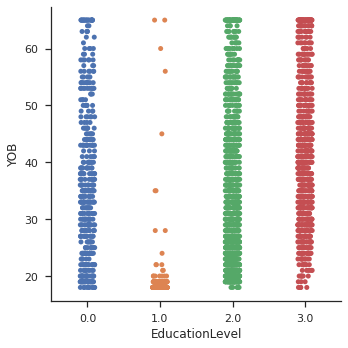

In [ ]:
# catplot of seaborn shows relationship between numerical variable and one or more categorical variables
sns.set(style="ticks", color_codes=True)
sns.catplot(x="EducationLevel", y="YOB", data=df1);

Here only few of them are having 'Doctorial Degree', most of them have stopped their education at highschool level and completed 'K12' before 22 years.

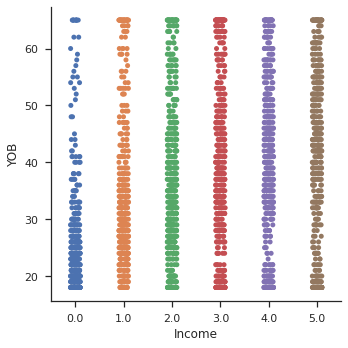

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="Income", y="YOB", data=df1);

only in the low income category, with the increase in the age income is decreasing. In the remaining all income categories with the increase in the 'age', 'Income' level is stable. 

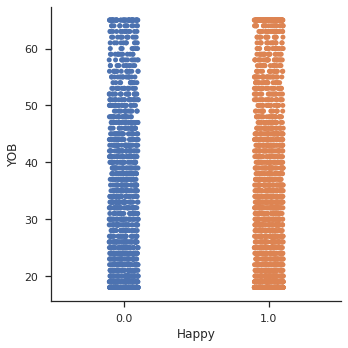

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="Happy", y="YOB", data=df1);

there are very few above 70 in both categories (Happy). and the ratio of male and female is constant. 

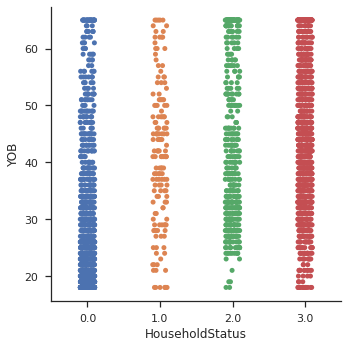

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.catplot(x="HouseholdStatus", y="YOB", data=df1);

only few Domestic partners (with and w/o kids) are above 50 Years. Most of them are single(w/o kids), Married (with and w/o kids). So while filling missing vlaues under HouseholeStatus 'age' can also be considered. But here used most probable value. 

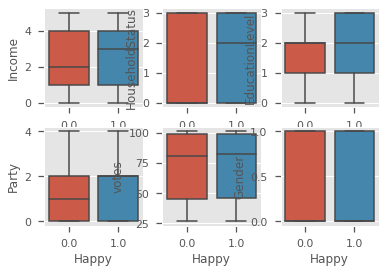

In [ ]:
# Plotting the features using boxes
plt.style.use('ggplot')
plt.subplot(2,3,1)
sns.boxplot(x = 'Happy', y = 'Income', data = df1)
plt.subplot(2,3,2)
sns.boxplot(x = 'Happy', y = 'HouseholdStatus', data = df1)
plt.subplot(2,3,3)
sns.boxplot(x = 'Happy', y = 'EducationLevel', data = df1)
plt.subplot(2,3,4)
sns.boxplot(x = 'Happy', y = 'Party', data = df1)
plt.subplot(2,3,5)
sns.boxplot(x = 'Happy', y = 'votes', data = df1)
plt.subplot(2,3,6)
sns.boxplot(x = 'Happy', y = 'Gender', data = df1)


IQR is used to identify the extreme values. Again box plot has been used to check the missed values. we can observe that there are no missed values.

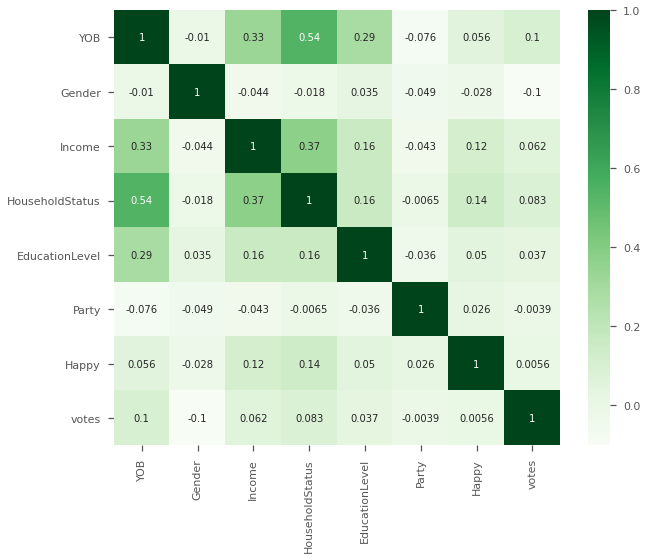

In [ ]:
df1_temp = df1[['YOB','Gender', 'Income', 'HouseholdStatus','EducationLevel', 'Party', 'Happy','votes']].copy()
#print(df1_temp)
plt.figure(figsize=(10,8))
sns.heatmap(df1_temp.corr(),cmap='Greens',annot=True)

From the above heat map 'YOB' is corelated with 'Income','HoueholdStatus' and 'EducationLevel'. 'Gender' is not corelated with any other attribute. So one can be used to fill the other in the dataset. Happy is also corelated with 'Income','HoueholdStatus' and 'EducationLevel' but not as "YOB"

In [ ]:
df1.select_dtypes(include='number').nunique() # no of unique values under each feature

YOB                48
Gender              2
Income              6
HouseholdStatus     4
EducationLevel      4
                   ..
Q98059              1
Q98078              2
Q98197              2
Q96024              2
votes              76
Length: 109, dtype: int64

In [ ]:
# feature engineering has been done by converting vote values to vote ranges 
#to check the dependency of 'Happy' on this feature
bins = [20, 30, 50, 70, 90, np.inf]
ranges = ['<30', '30-50', '50-70', '70-90', '90+']
df1['voteRange'] = pd.cut(df1['votes'], bins, labels=ranges)
df1.voteRange.value_counts()

90+      1948
70-90     727
30-50     678
<30       635
50-70     631
Name: voteRange, dtype: int64

Here divided the 'votes' feature into 'voteRange'. around 57% of the people have answered more than 70 Quesions. When it comes to UserID it is having too many distinct vlaues and it's an irrelevent feature so we can drop this.

In [ ]:
# devided the age into age ranges and added a new feature 'ageRange' in the dataset
bins = [13,20,30,40,50,60,np.inf]
ranges = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
df1['ageRange'] = pd.cut(df1['YOB'], bins, labels=ranges)
sorted(df1.ageRange.value_counts())
df1.ageRange.value_counts()

20-30    969
<20      863
30-40    817
40-50    605
50-60    359
60+      322
Name: ageRange, dtype: int64

In [ ]:
df1 = df1.replace({'ageRange': {'<20' :0, '20-30':1, '30-40':2,'40-50':3,'50-60':4,'60+':5}})

In [ ]:
df1 = df1.drop(['voteRange','ageRange'],axis=1)# removing voteRange

In [ ]:
df1

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,65.0,0.0,NaN,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,1.0,0.0,0.0,1.0,86.0
1,29.0,1.0,1.0,0.0,3.0,1.0,1.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,66.0
2,51.0,0.0,5.0,3.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101.0
3,18.0,0.0,3.0,0.0,0.0,2.0,1.0,NaN,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98.0
4,18.0,0.0,2.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4615,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4616,18.0,1.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4617,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8


<Figure size 432x288 with 0 Axes>

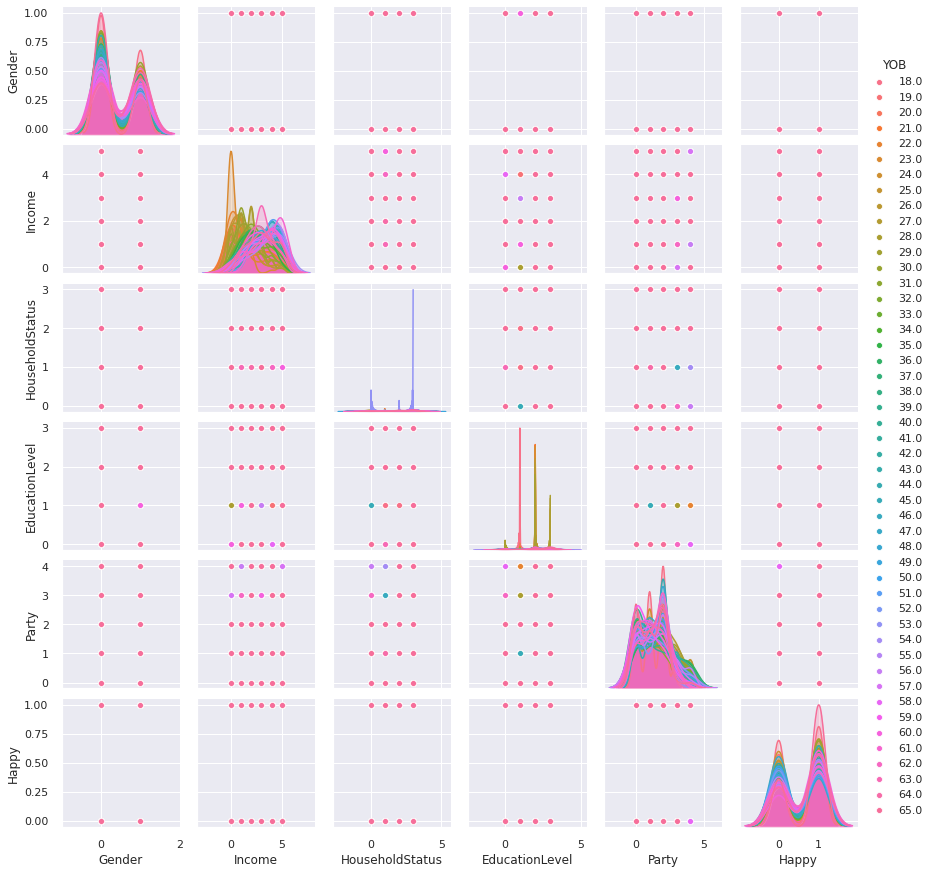

<Figure size 432x288 with 0 Axes>

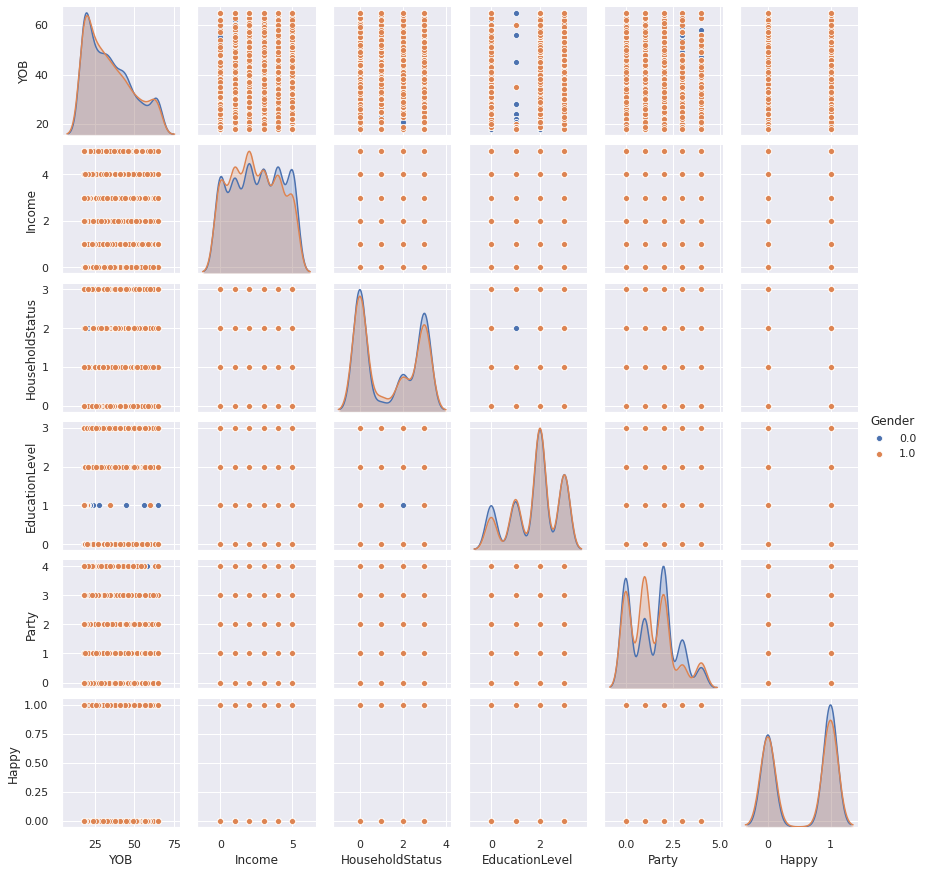

<Figure size 432x288 with 0 Axes>

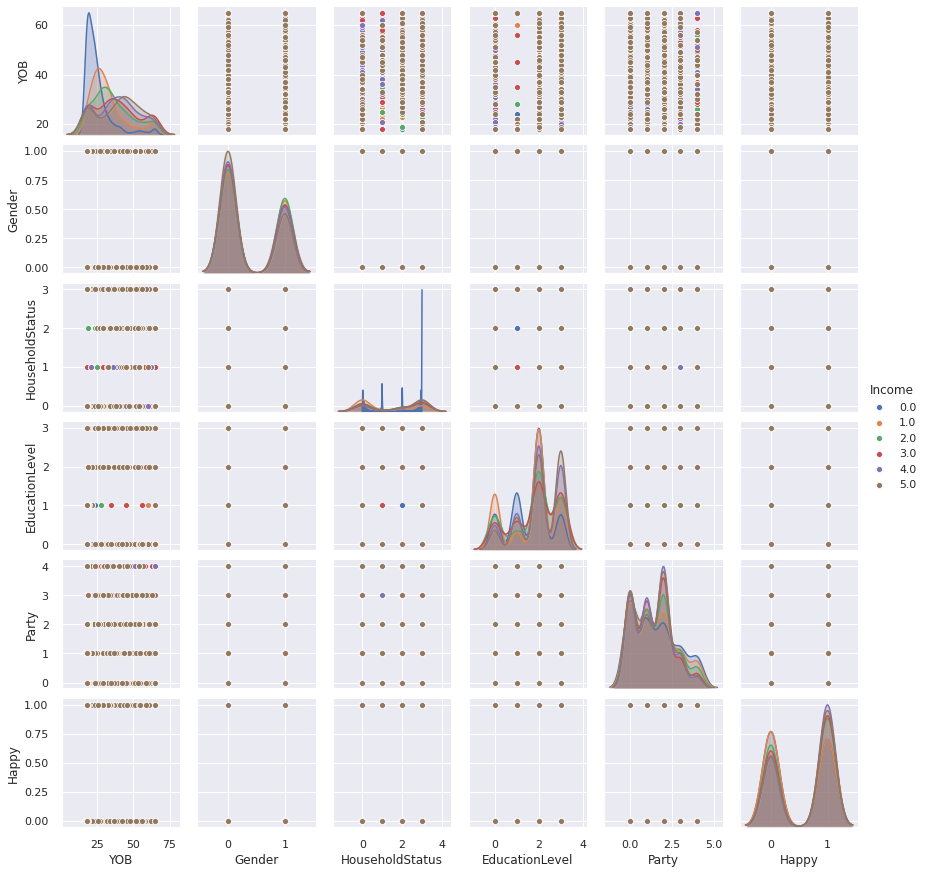

<Figure size 432x288 with 0 Axes>

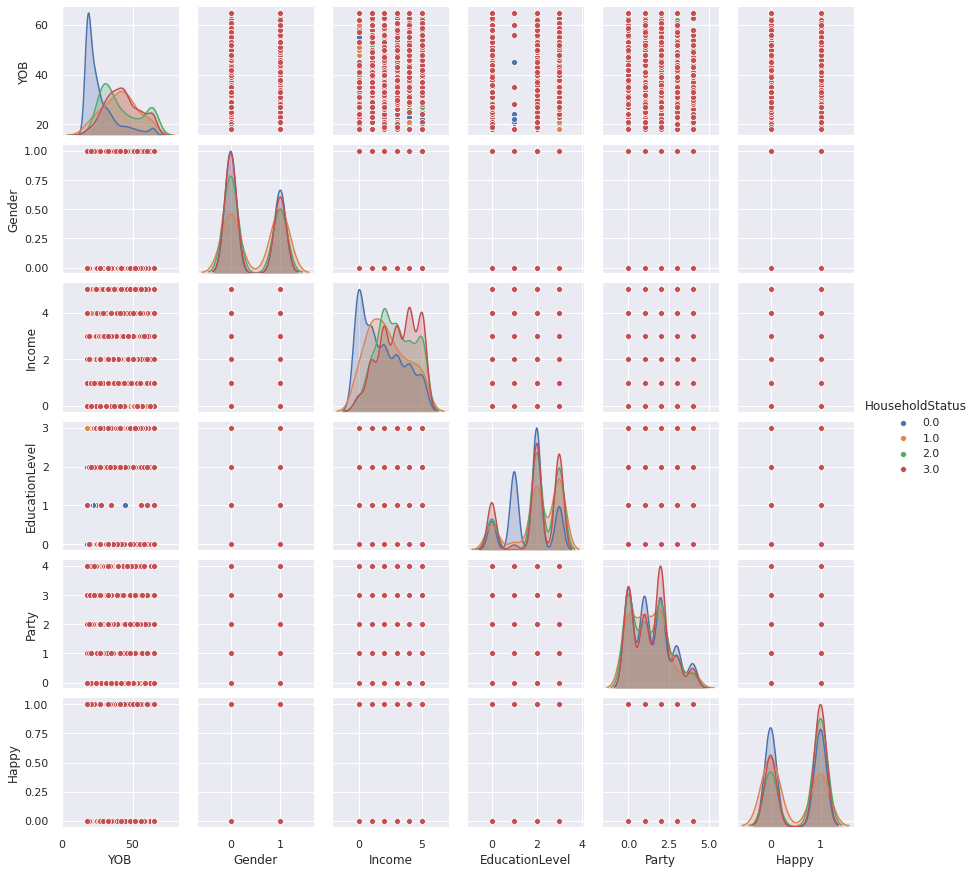

<Figure size 432x288 with 0 Axes>

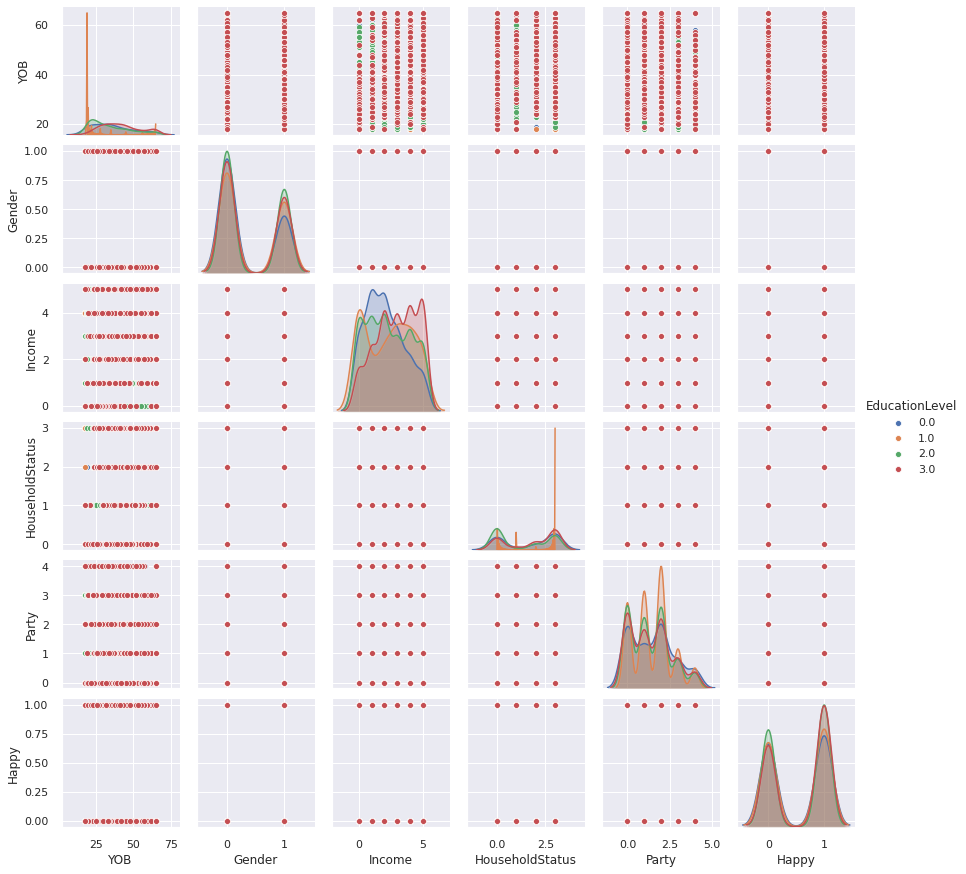

<Figure size 432x288 with 0 Axes>

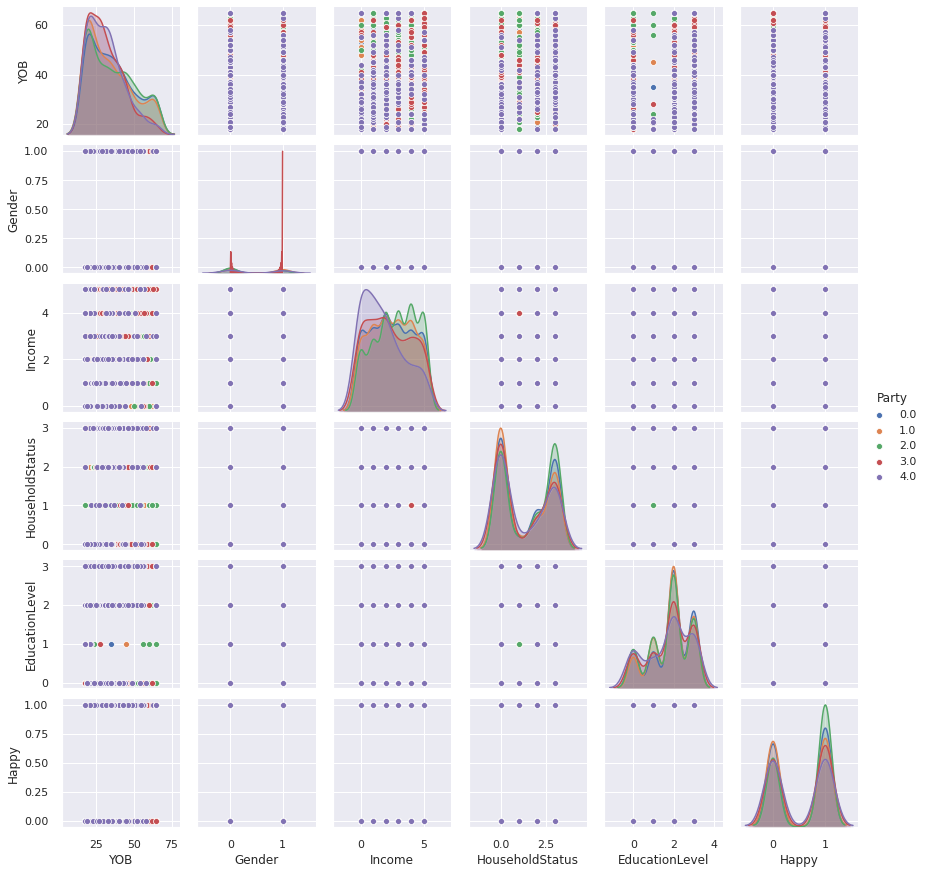

<Figure size 432x288 with 0 Axes>

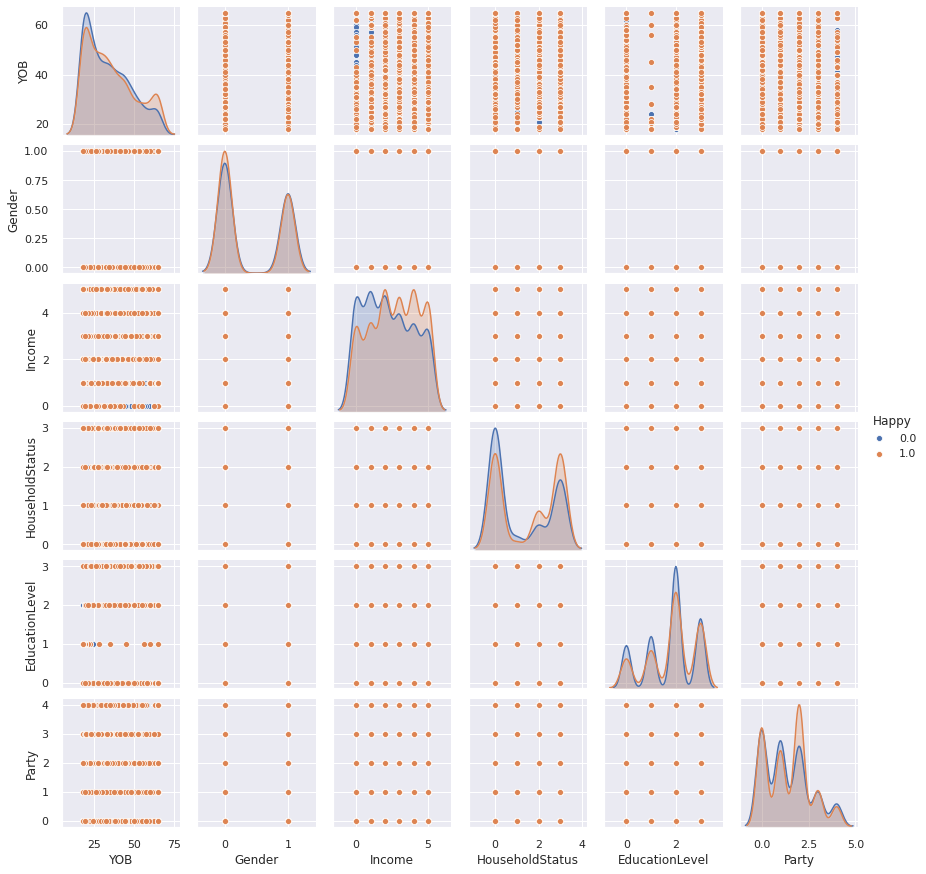

In [ ]:
df1_temp = df1[['YOB','Gender', 'Income', 'HouseholdStatus','EducationLevel', 'Party', 'Happy']].copy()
feature_list = ['YOB','Gender', 'Income', 'HouseholdStatus','EducationLevel', 'Party', 'Happy']
for i in feature_list:
  sns.set()
  features = ['YOB','Gender', 'Income', 'HouseholdStatus','EducationLevel', 'Party', 'Happy']
  plt.figure()
  sns.pairplot(df1_temp[features],size=2.0,hue =i)
  plt.show()

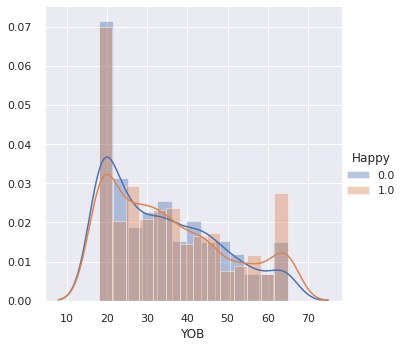

In [ ]:
# following plots shows the distribution of features before imputing the values
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "YOB") \
   .add_legend();
plt.show();
plt.close()

Both are overlapping till 22 after that there is some variation and there are some outliers after 78.

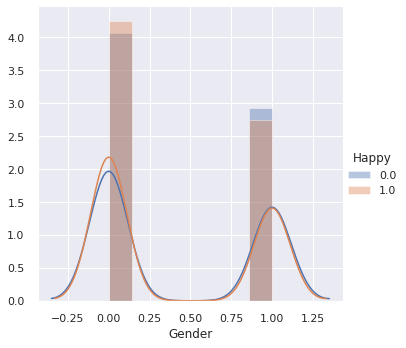

In [ ]:
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "Gender") \
   .add_legend();
plt.show();
plt.close()

Both are almost overlapping and there are no outliers

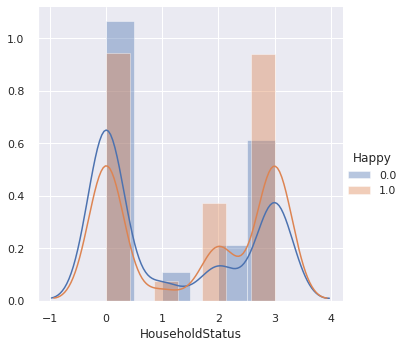

In [ ]:
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "HouseholdStatus") \
   .add_legend();
plt.show();
plt.close()

First and last categories are almost overlapping there is a difference in category 3 

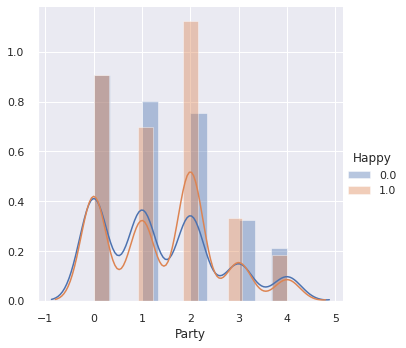

In [ ]:
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "Party") \
   .add_legend();
plt.show();
plt.close()

as we have seen in catplot there is a difference in republican category , remaining all are overlaping

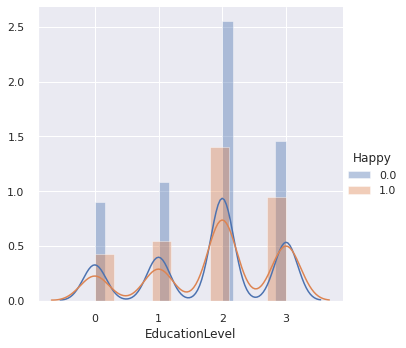

In [ ]:
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "EducationLevel") \
   .add_legend();
plt.show();
plt.close()

in all the categories majority of the people are happy. and there are very few in the last category

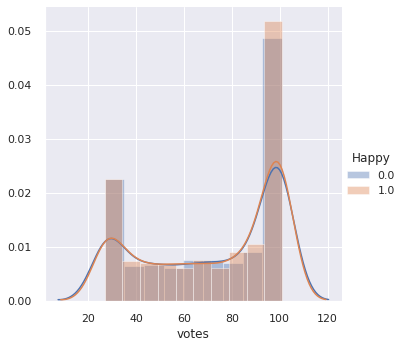

In [ ]:
sns.FacetGrid(df1, hue="Happy", size=5) \
   .map(sns.distplot, "votes") \
   .add_legend();
plt.show();
plt.close()

both ar eoverlapping. peopel who answered maximum number of questions are mor happy

This is same as 'YOB' category

---



In [ ]:
#sklearn SimpleImputer is used to fill the missing values. The featuers 'Gender', 
#'HouseholdStatus', 'Party' are categorical.so instead of mean/median considered 
#'most_frequent' strategy from SimpleImputer. As YOB' is a numerical feature so it is filled with mean value
from sklearn.impute import SimpleImputer

df_mean = df1[features_mean]# features with missing values between 5-20% missing
df_mean_test = df2[features_mean_test]

# age is replaced with mean
df_mean['YOB'].fillna(int(df_mean['YOB'].mean()), inplace=True)
df_mean_test['YOB'].fillna(int(df_mean_test['YOB'].mean()), inplace = True)

imp = SimpleImputer(strategy="most_frequent")
df_mean = imp.fit_transform(df1[features_mean])
df_mean_test = imp.transform(df2[features_mean_test])
for i in range(1,len(features_mean)):
    x = features_mean[i]
    df1[x] = df_mean[:,i].copy()
    
for i in range(1,len(features_mean_test)):
    x= features_mean_test[i]
    df2[x] = df_mean_test[:,i].copy()
    
    
df1['YOB'] = df_mean[:,0].copy()
df2['YOB'] = df_mean_test[:,0].copy()

In [ ]:
# KNN classifier has been used to predict the missing values 
from sklearn.neighbors import KNeighborsClassifier
def impute_model_basic(df):
    # taken columns with null values into 'cols_nan'
    cols_nan = df.columns[df.isna().any()].tolist()    
    # taken columns with non null values into 'cols_no_nan'
    cols_no_nan = df.columns.difference(cols_nan).values    
    for col in cols_nan:
        test_data = df[df[col].isna()]# rows with null values are taken into testset
        train_data = df.dropna()#remaining into train
        #Kneighbors classifier is applied
        knr = KNeighborsClassifier(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
        #predict each test row with the trained model
        df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
        #updating columns with nan and without nan for updating train and test with new predicted rows
        cols_nan = df.columns[df.isna().any()].tolist()    
        cols_no_nan = df.columns.difference(cols_nan).values
    return df

In [ ]:
df_impu = impute_model_basic(df1)
df_impu

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,65.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,86.0
1,29.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.0
2,51.0,0.0,5.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101.0
3,18.0,0.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98.0
4,18.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,18.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,26.8
4615,18.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,26.8
4616,18.0,1.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,26.8
4617,18.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,26.8


Distribution of the data after imputing the values

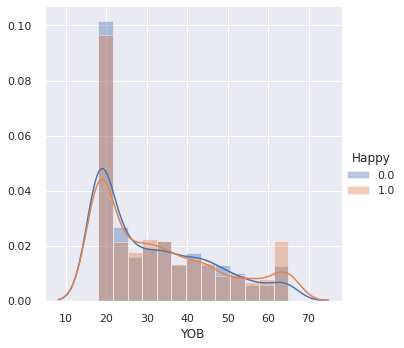

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "YOB") \
   .add_legend();
plt.show();

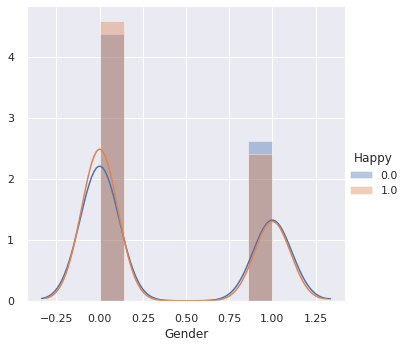

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "Gender") \
   .add_legend();
plt.show();

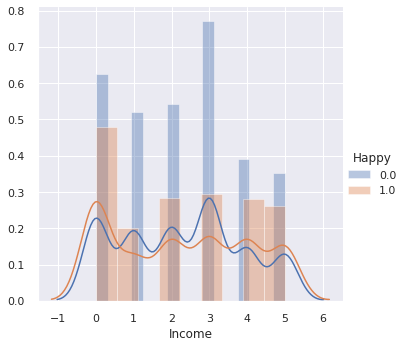

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "Income") \
   .add_legend();
plt.show();

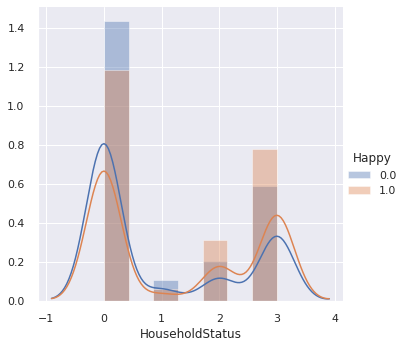

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "HouseholdStatus") \
   .add_legend();
plt.show();

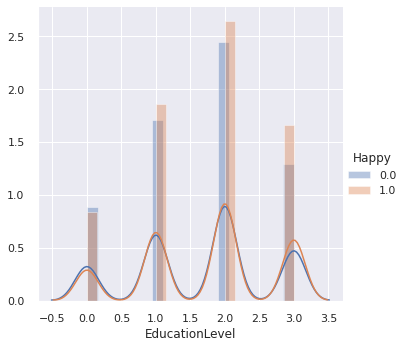

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "EducationLevel") \
   .add_legend();
plt.show();

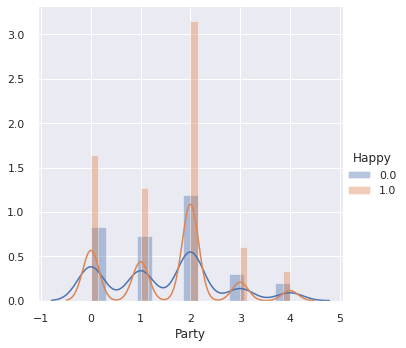

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "Party") \
   .add_legend();
plt.show();

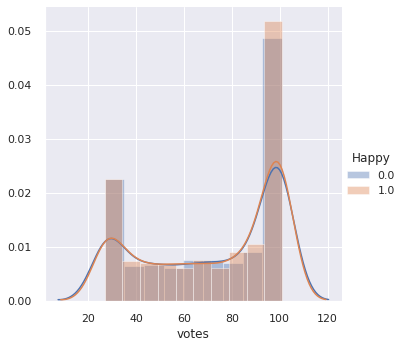

In [ ]:
sns.FacetGrid(df_impu, hue="Happy", size=5) \
   .map(sns.distplot, "votes") \
   .add_legend();
plt.show();

There is no much difference in the distribution of the data before and after imputing the values

In [ ]:
df_impu_test = impute_model_basic(df2)# imputing the test data
df_impu_test

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,31.0,0.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,49
1,44.0,1.0,5.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75
2,34.0,1.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101
3,31.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,60
4,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,21
1976,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,21
1977,18.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,21
1978,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,21


In [ ]:
from sklearn.preprocessing import LabelEncoder
y = df_impu.Happy # separating the class label
X = df_impu.drop(['Happy'],axis = 1) # taking remaining features
print(type(X))
# deviding the data int otrain and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 50)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

label_encoder = LabelEncoder() # 
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

<class 'pandas.core.frame.DataFrame'>
(3464, 108) (1155, 108) (3464,) (1155,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
y = df_impu.Happy # separating the class label
X = df_impu.drop(['Happy'],axis = 1) # taking remaining features

# deviding the data int otrain and test
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20,random_state = 50)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

label_encoder = LabelEncoder() # 
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

(3695, 108) (1155, 108) (3695,) (1155,)


In [ ]:
X_train.columns

Index(['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party',
       'Q124742', 'Q124122', 'Q123464', 'Q123621',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=108)

In [ ]:
df_impu_test.columns

Index(['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party',
       'Q124742', 'Q124122', 'Q123464', 'Q123621',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=108)

In [ ]:
scaler = StandardScaler() #standardising the data
scaled_data_tr = scaler.fit_transform(X_train) 
scaled_data_te = scaler.transform(X_test)
print(scaled_data_tr)

scaled_data_df2 = scaler.transform(df_impu_test)
print(scaled_data_df2.shape)

[[ 0.31677215 -0.74595229 -1.32850868 ... -0.77700234  0.74727115
   0.40896454]
 [-0.98117281  1.34056831 -1.32850868 ...  1.28699741 -1.33820234
  -0.0214141 ]
 [-0.98117281 -0.74595229  0.43198369 ... -0.77700234  0.74727115
  -1.64250701]
 ...
 [ 0.52171083 -0.74595229  1.01881448 ... -0.77700234  0.74727115
   0.98280274]
 [ 1.54640422  1.34056831  1.60564527 ...  1.28699741  0.74727115
   0.30136988]
 [ 2.22953315  1.34056831  0.43198369 ... -0.77700234  0.74727115
   1.01866763]]
(1980, 108)


In [ ]:
pip install statsmodels

In [ ]:
# checking for multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

VIF stands for Variance Inflation Factor. During regression analysis, VIF assesses whether features are correlated to each other or not. Values of VIF that exceed 10 are often regarded as indicating multicollinearity

In [ ]:
# computing VIF for all columns in a given dataset
scaled_data_tr = pd.DataFrame(scaled_data_tr, columns=X_train.columns)
scaled_data_te = pd.DataFrame(scaled_data_te, columns=X_train.columns)
scaled_data_df2 = pd.DataFrame(scaled_data_df2, columns=X_train.columns)

vif_tr = calc_vif(scaled_data_tr)
vif_te = calc_vif(scaled_data_te)
print(vif_tr)
print(vif_te)
print(scaled_data_te.columns)
print(scaled_data_te.columns)

           variables       VIF
0                YOB  3.334650
1             Gender  1.429346
2             Income  1.459151
3    HouseholdStatus  2.306122
4     EducationLevel  1.295855
..               ...       ...
103           Q98059       NaN
104           Q98078  1.146221
105           Q98197  1.635860
106           Q96024  1.146641
107            votes  3.679497

[108 rows x 2 columns]
           variables       VIF
0                YOB  3.685614
1             Gender  1.564523
2             Income  1.546274
3    HouseholdStatus  2.487354
4     EducationLevel  1.456901
..               ...       ...
103           Q98059       NaN
104           Q98078  1.221741
105           Q98197  1.785864
106           Q96024  1.168212
107            votes  3.756293

[108 rows x 2 columns]
Index(['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party',
       'Q124742', 'Q124122', 'Q123464', 'Q123621',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059',

In [ ]:
#scaled_data_tr1 = scaled_data_tr.drop(['YOB','votes'],axis=1)
#scaled_data_te1 = scaled_data_te.drop(['YOB','votes'],axis=1)
#alc_vif(scaled_data_tr1)

In [ ]:
scaled_data_tr

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,0.316772,-0.745952,-1.328509,-0.862913,0.306141,-1.357001,-0.644755,-1.314896,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,1.001896,-1.261414,0.982029,0.0,-0.549103,1.519200,-0.736311,0.718910,0.966724,-0.728896,-0.476620,-1.483882,-0.985758,-0.893338,-0.511393,-0.730638,0.582038,1.558090,1.746864,-0.924115,0.952158,0.385931,1.565262,-0.710267,...,-0.311593,-0.547851,-0.571204,0.607892,1.349300,1.040607,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,-0.804123,1.157622,0.854798,-0.902187,0.944437,-0.600380,1.399417,-0.894809,1.807414,-1.680789,0.810983,0.896280,-0.701230,0.813278,-1.407067,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,-2.203584,1.321049,0.0,1.095173,-0.777002,0.747271,0.408965
1,-0.981173,1.340568,-1.328509,-0.862913,-0.742228,0.450540,1.550977,0.760516,-0.211354,-0.973557,-0.681562,0.779692,-0.374273,1.331143,-1.953835,-0.513077,-0.998107,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,0.966724,-0.728896,-0.476620,0.673908,1.014448,1.119397,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,1.082116,0.952158,0.385931,-0.638870,-0.710267,...,-0.311593,-0.547851,1.750687,0.607892,-0.741125,-0.960977,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,-0.804123,-0.863840,0.854798,1.108417,-1.058832,-0.600380,-0.714584,1.117558,1.807414,-1.680789,0.810983,0.896280,-0.701230,-1.229592,0.710698,-2.248861,-0.965677,0.419527,-0.298878,-0.339068,0.477903,0.453806,1.321049,0.0,1.095173,1.286997,-1.338202,-0.021414
2,-0.981173,-0.745952,0.431984,-0.862913,-0.742228,0.450540,-0.644755,-1.314896,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,1.331143,-1.953835,-0.513077,-0.998107,0.792761,-1.018300,0.0,1.821150,-0.658241,1.358122,-1.390996,-1.034422,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,1.082116,-1.050246,0.385931,-0.638870,-0.710267,...,-0.311593,-0.547851,-0.571204,0.607892,-0.741125,-0.960977,0.335085,0.386394,0.752998,-1.267195,-0.539495,0.932705,-0.804123,-0.863840,0.854798,-0.902187,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,0.594959,-1.233071,0.896280,-0.701230,-1.229592,0.710698,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,1.095173,-0.777002,0.747271,-1.642507
3,1.341466,1.340568,1.018814,-0.862913,0.306141,0.450540,-0.644755,-1.314896,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,-0.998107,-1.261414,-1.018300,0.0,-0.549103,-0.658241,-0.736311,-1.390996,-1.034422,1.371939,-0.476620,0.673908,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,1.746864,-0.924115,0.952158,0.385931,1.565262,-0.710267,...,-0.311593,-0.547851,1.750687,0.607892,-0.741125,1.040607,0.335085,0.386394,-1.328025,0.789145,-0.539495,0.932705,-0.804123,-0.863840,0.854798,1.108417,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,-1.680789,0.810983,0.896280,-0.701230,0.813278,-1.407067,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,-0.913097,-0.777002,-1.338202,1.018668
4,-0.434670,-0.745952,-1.328509,-0.862913,0.306141,-1.357001,1.550977,0.760516,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,1.949026,-0.998107,0.792761,0.982029,0.0,-0.549103,1.519200,1.358122,0.718910,0.966724,-0.728896,-0.476620,-1.483882,-0.985758,-0.893338,-0.511393,-0.730638,0.582038,-0.64

In [ ]:
scaled_data_te

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,-0.161418,1.340568,-0.741678,-0.862913,0.306141,-1.357001,-0.644755,-1.314896,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,-0.513077,-0.998107,0.792761,-1.018300,0.0,1.821150,-0.658241,-0.736311,-1.390996,0.966724,1.371939,-0.476620,0.673908,-0.985758,-0.893338,1.955444,1.368667,0.582038,-0.641812,-0.572454,-0.924115,0.952158,0.385931,-0.638870,1.407922,...,-0.311593,-0.547851,-0.571204,0.607892,1.349300,-0.960977,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,1.243591,-0.863840,-1.169867,1.108417,-1.058832,-0.600380,-0.714584,-0.894809,-0.553277,-1.680789,0.810983,0.896280,-0.701230,-1.229592,0.710698,-2.248861,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,1.321049,0.0,1.095173,1.286997,-1.338202,0.660019
1,-0.844547,1.340568,-0.154847,-0.862913,0.306141,-1.357001,-0.644755,0.760516,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,1.331143,-1.953835,-0.513077,1.001896,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,-1.034422,-0.728896,-0.476620,0.673908,1.014448,1.119397,-0.511393,-0.730638,0.582038,1.558090,-0.572454,1.082116,0.952158,-2.591136,-0.638870,1.407922,...,-0.311593,-0.547851,-0.571204,-1.645028,1.349300,1.040607,0.335085,0.386394,0.752998,-1.267195,-0.539495,-1.072150,-0.804123,1.157622,0.854798,1.108417,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,0.594959,-1.233071,-1.115722,-0.701230,-1.229592,0.710698,0.444669,-0.965677,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,1.095173,1.286997,0.747271,0.946938
2,0.385085,-0.745952,-0.154847,-0.862913,1.354509,-1.357001,1.550977,0.760516,-0.211354,1.027162,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,1.949026,1.001896,0.792761,0.982029,0.0,1.821150,-0.658241,-0.736311,0.718910,-1.034422,1.371939,2.098106,-1.483882,-0.985758,1.119397,-0.511393,-0.730638,-1.718101,1.558090,-0.572454,-0.924115,-1.050246,0.385931,1.565262,1.407922,...,-0.311593,1.825314,-0.571204,0.607892,-0.741125,1.040607,-2.984320,0.386394,0.752998,0.789145,1.853584,0.932705,-0.804123,-0.863840,0.854798,1.108417,0.944437,1.665611,-0.714584,-0.894809,1.807414,-1.680789,0.810983,-1.115722,-0.701230,0.813278,0.710698,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,-2.203584,-0.756974,0.0,-0.913097,-0.777002,0.747271,0.337235
3,0.043521,-0.745952,-0.154847,-0.862913,0.306141,0.450540,1.550977,0.760516,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,1.001896,-1.261414,-1.018300,0.0,-0.549103,-0.658241,-0.736311,0.718910,-1.034422,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,1.955444,1.368667,-1.718101,-0.641812,1.746864,-0.924115,0.952158,-2.591136,1.565262,1.407922,...,-0.311593,-0.547851,1.750687,0.607892,-0.741125,1.040607,-2.984320,-2.588033,0.752998,0.789145,-0.539495,0.932705,1.243591,1.157622,0.854798,1.108417,-1.058832,1.665611,-0.714584,-0.894809,-0.553277,0.594959,0.810983,0.896280,1.426065,0.813278,-1.407067,0.444669,1.035543,0.419527,3.345851,-0.339068,0.477903,-2.203584,-0.756974,0.0,-0.913097,-0.777002,0.747271,0.911073
4,0.521711,1.340568,0.431984,1.340587,-1.790596,0.450540,-0.644755,-1.314896,-0.211354,1.027162,1.467219,-1.282557,-0.374273,-0.751234,0.511814,-0.513077,1.001896,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,0.966724,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,-

In [ ]:
scaled_data_tr1_q = scaled_data_tr[scaled_data_tr.columns[5:106]] .copy()
scaled_data_te1_q = scaled_data_te[scaled_data_te.columns[5:106]] .copy()

In [ ]:
scaled_data_tr1_q

,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,Q116197,Q115602,Q115777,Q115610,Q115611,...,Q109244,Q108855,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197
0,-1.357001,-0.644755,-1.314896,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,1.001896,-1.261414,0.982029,0.0,-0.549103,1.519200,-0.736311,0.718910,0.966724,-0.728896,-0.476620,-1.483882,-0.985758,-0.893338,-0.511393,-0.730638,0.582038,1.558090,1.746864,-0.924115,0.952158,0.385931,1.565262,-0.710267,0.606640,0.434149,-0.681136,0.606222,1.297447,...,-0.630479,0.688384,-0.311593,-0.547851,-0.571204,0.607892,1.349300,1.040607,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,-0.804123,1.157622,0.854798,-0.902187,0.944437,-0.600380,1.399417,-0.894809,1.807414,-1.680789,0.810983,0.896280,-0.701230,0.813278,-1.407067,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,-2.203584,1.321049,0.0,1.095173,-0.777002
1,0.450540,1.550977,0.760516,-0.211354,-0.973557,-0.681562,0.779692,-0.374273,1.331143,-1.953835,-0.513077,-0.998107,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,0.966724,-0.728896,-0.476620,0.673908,1.014448,1.119397,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,1.082116,0.952158,0.385931,-0.638870,-0.710267,0.606640,0.434149,-0.681136,0.606222,-0.770744,...,1.586096,0.688384,-0.311593,-0.547851,1.750687,0.607892,-0.741125,-0.960977,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,-0.804123,-0.863840,0.854798,1.108417,-1.058832,-0.600380,-0.714584,1.117558,1.807414,-1.680789,0.810983,0.896280,-0.701230,-1.229592,0.710698,-2.248861,-0.965677,0.419527,-0.298878,-0.339068,0.477903,0.453806,1.321049,0.0,1.095173,1.286997
2,0.450540,-0.644755,-1.314896,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,1.331143,-1.953835,-0.513077,-0.998107,0.792761,-1.018300,0.0,1.821150,-0.658241,1.358122,-1.390996,-1.034422,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,1.082116,-1.050246,0.385931,-0.638870,-0.710267,0.606640,0.434149,-0.681136,-1.649560,-0.770744,...,-0.630479,0.688384,-0.311593,-0.547851,-0.571204,0.607892,-0.741125,-0.960977,0.335085,0.386394,0.752998,-1.267195,-0.539495,0.932705,-0.804123,-0.863840,0.854798,-0.902187,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,0.594959,-1.233071,0.896280,-0.701230,-1.229592,0.710698,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,1.095173,-0.777002
3,0.450540,-0.644755,-1.314896,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,-0.998107,-1.261414,-1.018300,0.0,-0.549103,-0.658241,-0.736311,-1.390996,-1.034422,1.371939,-0.476620,0.673908,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,1.746864,-0.924115,0.952158,0.385931,1.565262,-0.710267,0.606640,0.434149,-0.681136,0.606222,-0.770744,...,-0.630479,0.688384,-0.311593,-0.547851,1.750687,0.607892,-0.741125,1.040607,0.335085,0.386394,-1.328025,0.789145,-0.539495,0.932705,-0.804123,-0.863840,0.854798,1.108417,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,-1.680789,0.810983,0.896280,-0.701230,0.813278,-1.407067,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,-0.913097,-0.777002
4,-1.357001,1.550977,0.760516,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,1.949026,-0.998107,0.792761,0.982029,0.0,-0.549103,1.519200,1.358122,0.718910,0.966724,-0.728896,-0.476620,-1.483882,-0.985758,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,1.746864,1.082116,0.952158,0.385931,1.565262,-0.710267,

In [ ]:
scaled_data_te1_q

,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,Q116197,Q115602,Q115777,Q115610,Q115611,...,Q109244,Q108855,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197
0,-1.357001,-0.644755,-1.314896,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,-0.513077,-0.998107,0.792761,-1.018300,0.0,1.821150,-0.658241,-0.736311,-1.390996,0.966724,1.371939,-0.476620,0.673908,-0.985758,-0.893338,1.955444,1.368667,0.582038,-0.641812,-0.572454,-0.924115,0.952158,0.385931,-0.638870,1.407922,0.606640,0.434149,-0.681136,0.606222,1.297447,...,1.586096,-1.452677,-0.311593,-0.547851,-0.571204,0.607892,1.349300,-0.960977,0.335085,0.386394,-1.328025,-1.267195,-0.539495,-1.072150,1.243591,-0.863840,-1.169867,1.108417,-1.058832,-0.600380,-0.714584,-0.894809,-0.553277,-1.680789,0.810983,0.896280,-0.701230,-1.229592,0.710698,-2.248861,1.035543,0.419527,-0.298878,-0.339068,0.477903,0.453806,1.321049,0.0,1.095173,1.286997
1,-1.357001,-0.644755,0.760516,-0.211354,-0.973557,-0.681562,-1.282557,-0.374273,1.331143,-1.953835,-0.513077,1.001896,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,-1.034422,-0.728896,-0.476620,0.673908,1.014448,1.119397,-0.511393,-0.730638,0.582038,1.558090,-0.572454,1.082116,0.952158,-2.591136,-0.638870,1.407922,0.606640,0.434149,-0.681136,0.606222,-0.770744,...,1.586096,-1.452677,-0.311593,-0.547851,-0.571204,-1.645028,1.349300,1.040607,0.335085,0.386394,0.752998,-1.267195,-0.539495,-1.072150,-0.804123,1.157622,0.854798,1.108417,0.944437,-0.600380,-0.714584,-0.894809,-0.553277,0.594959,-1.233071,-1.115722,-0.701230,-1.229592,0.710698,0.444669,-0.965677,0.419527,-0.298878,-0.339068,0.477903,0.453806,-0.756974,0.0,1.095173,1.286997
2,-1.357001,1.550977,0.760516,-0.211354,1.027162,-0.681562,-1.282557,-0.374273,-0.751234,0.511814,1.949026,1.001896,0.792761,0.982029,0.0,1.821150,-0.658241,-0.736311,0.718910,-1.034422,1.371939,2.098106,-1.483882,-0.985758,1.119397,-0.511393,-0.730638,-1.718101,1.558090,-0.572454,-0.924115,-1.050246,0.385931,1.565262,1.407922,0.606640,0.434149,-0.681136,0.606222,1.297447,...,-0.630479,-1.452677,-0.311593,1.825314,-0.571204,0.607892,-0.741125,1.040607,-2.984320,0.386394,0.752998,0.789145,1.853584,0.932705,-0.804123,-0.863840,0.854798,1.108417,0.944437,1.665611,-0.714584,-0.894809,1.807414,-1.680789,0.810983,-1.115722,-0.701230,0.813278,0.710698,0.444669,1.035543,0.419527,-0.298878,-0.339068,0.477903,-2.203584,-0.756974,0.0,-0.913097,-0.777002
3,0.450540,1.550977,0.760516,-0.211354,1.027162,1.467219,0.779692,-0.374273,-0.751234,0.511814,-0.513077,1.001896,-1.261414,-1.018300,0.0,-0.549103,-0.658241,-0.736311,0.718910,-1.034422,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,1.955444,1.368667,-1.718101,-0.641812,1.746864,-0.924115,0.952158,-2.591136,1.565262,1.407922,0.606640,0.434149,-0.681136,-1.649560,-0.770744,...,-0.630479,-1.452677,-0.311593,-0.547851,1.750687,0.607892,-0.741125,1.040607,-2.984320,-2.588033,0.752998,0.789145,-0.539495,0.932705,1.243591,1.157622,0.854798,1.108417,-1.058832,1.665611,-0.714584,-0.894809,-0.553277,0.594959,0.810983,0.896280,1.426065,0.813278,-1.407067,0.444669,1.035543,0.419527,3.345851,-0.339068,0.477903,-2.203584,-0.756974,0.0,-0.913097,-0.777002
4,0.450540,-0.644755,-1.314896,-0.211354,1.027162,1.467219,-1.282557,-0.374273,-0.751234,0.511814,-0.513077,1.001896,0.792761,0.982029,0.0,-0.549103,-0.658241,-0.736311,0.718910,0.966724,-0.728896,-0.476620,-1.483882,1.014448,-0.893338,-0.511393,-0.730638,0.582038,-0.641812,-0.572454,-0.924115,0.952158,-2.591136,-0.638870,-0.710267,0.60

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(scaled_data_tr1_q, y_train)

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
#['Q98197', 'Q119334', 'Q108855', 'Q102906', 'Q98869', 'Q121011', 'Q102289', 'Q107869', 'Q101162', 'Q118237']
perm = PermutationImportance(my_model, random_state=1).fit(scaled_data_te1_q, y_test)
eli5.show_weights(perm, feature_names = scaled_data_te1_q.columns.tolist())

Weight,Feature
0.0203 ± 0.0095,Q118237
0.0149 ± 0.0072,Q101162
0.0092 ± 0.0018,Q119334
0.0074 ± 0.0063,Q106272
0.0055 ± 0.0043,Q98869
0.0048 ± 0.0052,Q104996
0.0045 ± 0.0071,Q121011
0.0043 ± 0.0072,Q111848
0.0043 ± 0.0063,Q107869
0.0038 ± 0.0072,Q116197


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import operator
dict1 ={}
model = RandomForestRegressor()
# fit the model
model.fit(scaled_data_tr1_q, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
  dict1[i]=v
  #print('Feature: %0d, Score: %.5f' % (i,v))

# take important features into a dictionary
sorted_d = sorted(dict1.items(), key=operator.itemgetter(1))
print(sorted_d)
# takje top 10 features
top_fea = sorted_d[-10:]
#print(type(top_fea[0]))
top_feas = []

for a_tuple in top_fea:
	top_feas.append(a_tuple[0])

#extract the top 10 feature names
top_feas_names = []
for i in top_feas:
  f = scaled_data_tr1_q.columns[i]
  top_feas_names.append(f)
print(top_feas_names)

In [ ]:
top_feas_names.append('Gender')
top_feas_names.append('Income')
top_feas_names.append('HouseholdStatus')
top_feas_names.append('EducationLevel')
top_feas_names.append('Party')

top_feas_names 

['Q98869',
 'Q119334',
 'Q120014',
 'Q98578',
 'Q124742',
 'Q102906',
 'Q107869',
 'Party',
 'Q101162',
 'Q118237',
 'Gender',
 'Income',
 'HouseholdStatus',
 'EducationLevel',
 'Party']

In [ ]:
# take top 10 important questions along with other features in to final dataframe train and test set
f_df_tr = pd.DataFrame(scaled_data_tr[top_feas_names])
f_df_te = pd.DataFrame(scaled_data_te[top_feas_names])
print(f_df_tr.shape)
f_df_te.shape


(3695, 15)


(1155, 15)

In [ ]:
l = ['Q118237','Q101162','Q102089','Q102906','Q115777','Q102674','Q120014','Q124742','Q117186','Q114386','Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party']
f_df_tr1 = pd.DataFrame(scaled_data_tr[l])
f_df_te1 = pd.DataFrame(scaled_data_te[l])
print(f_df_tr1.shape)
f_df_te1.shape

(3695, 15)


(1155, 15)

In [ ]:
from yellowbrick.features import Rank1D

# Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(features=features, algorithm='shapiro')

visualizer.fit(scaled_data_tr1_q, y_train)                # Fit the data to the visualizer
#visualizer.transform(X)             # Transform the data
visualizer.poof()    

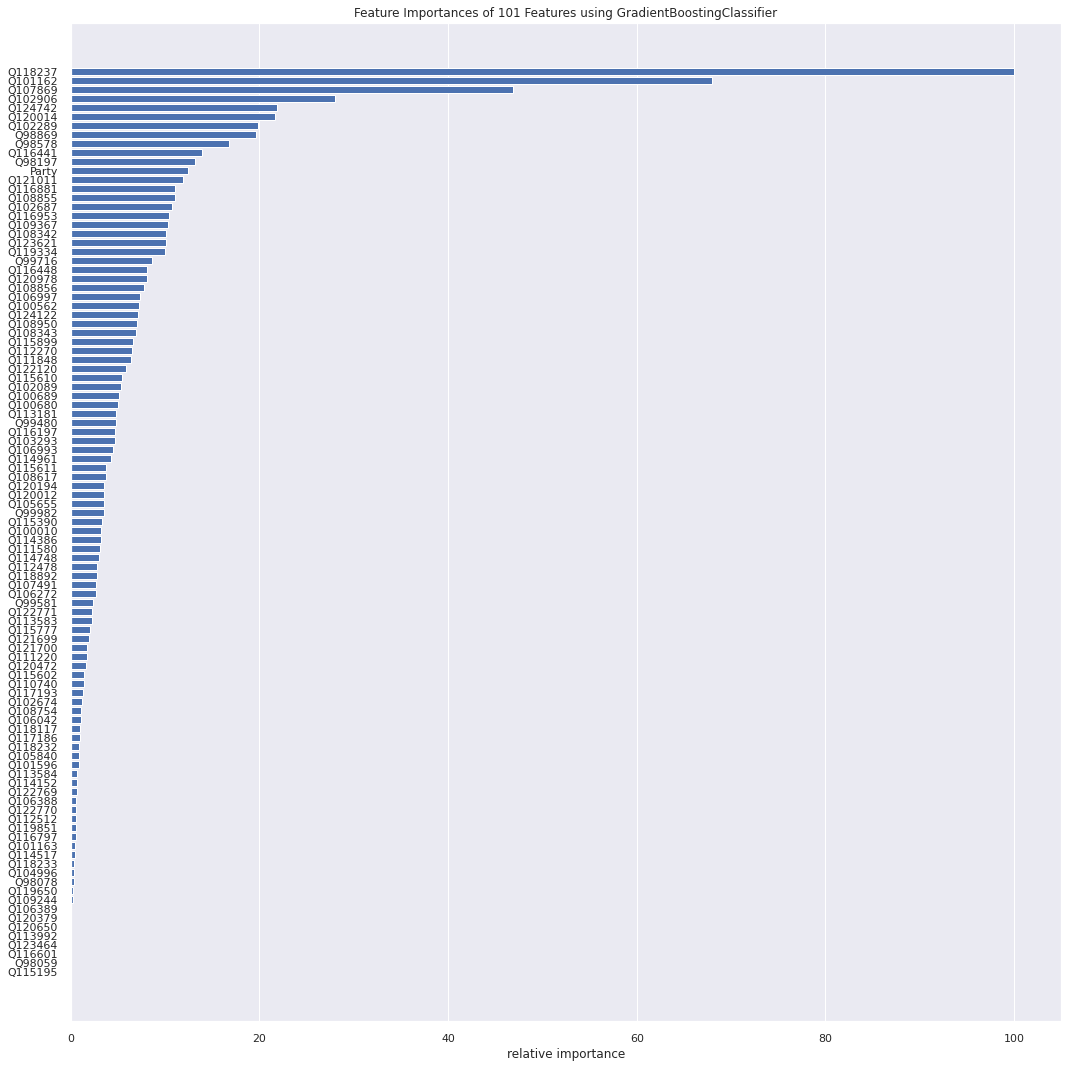

In [ ]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(scaled_data_tr1_q, y_train)
viz.poof()

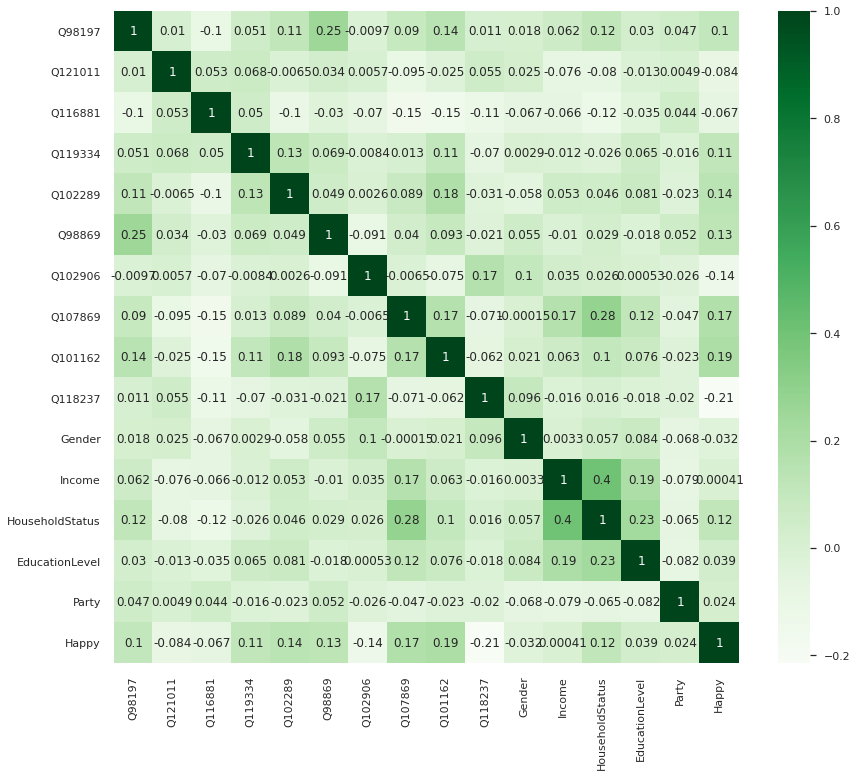

In [ ]:
df1_temp = df_impu[['Q98197', 'Q121011', 'Q116881', 'Q119334', 'Q102289', 'Q98869', 'Q102906', 'Q107869', 'Q101162', 'Q118237','Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party','Happy']].copy()
plt.figure(figsize=(14,12))
sns.heatmap(df1_temp.corr(),cmap='Greens',annot=True)

Above are the top 10 features whch are selected with high importance using RandomForestRegressor

In [ ]:
from sklearn.utils.multiclass import type_of_target
print(type_of_target(y_train))
print(type_of_target(y_test))
len(y_train)

binary
binary


3695

In [ ]:
scaled_data_tr.columns

Index(['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party',
       'Q124742', 'Q124122', 'Q123464', 'Q123621',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=108)

In [ ]:
scaled_data_df2.columns

Index(['YOB', 'Gender', 'Income', 'HouseholdStatus', 'EducationLevel', 'Party',
       'Q124742', 'Q124122', 'Q123464', 'Q123621',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=108)


**SVC with SGDClassifier**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import math
svm = SGDClassifier(class_weight='balanced')
parameters = {'loss' :['hinge'],'penalty' :["l1", "l2"],'alpha':[abs(math.log10(10**1)),abs(math.log10(10**2)),abs(math.log10(10**3)),abs(math.log10(10**4))\
                       ,abs(math.log10(10**5)),abs(math.log10(10**6)),abs(math.log10(10**7))\
                       ,abs(math.log10(10**8))]}

clf = GridSearchCV(svm, parameters, cv= 10, scoring='roc_auc')
grid_result = clf.fit(scaled_data_tr,y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.7220428417882652
Best Params:  {'alpha': 1.0, 'loss': 'hinge', 'penalty': 'l2'}


[1 0 0 ... 1 0 0]
[ 0.98964827  0.7603228  -0.83251952 ...  0.5545055   0.43472845
  0.14181356]


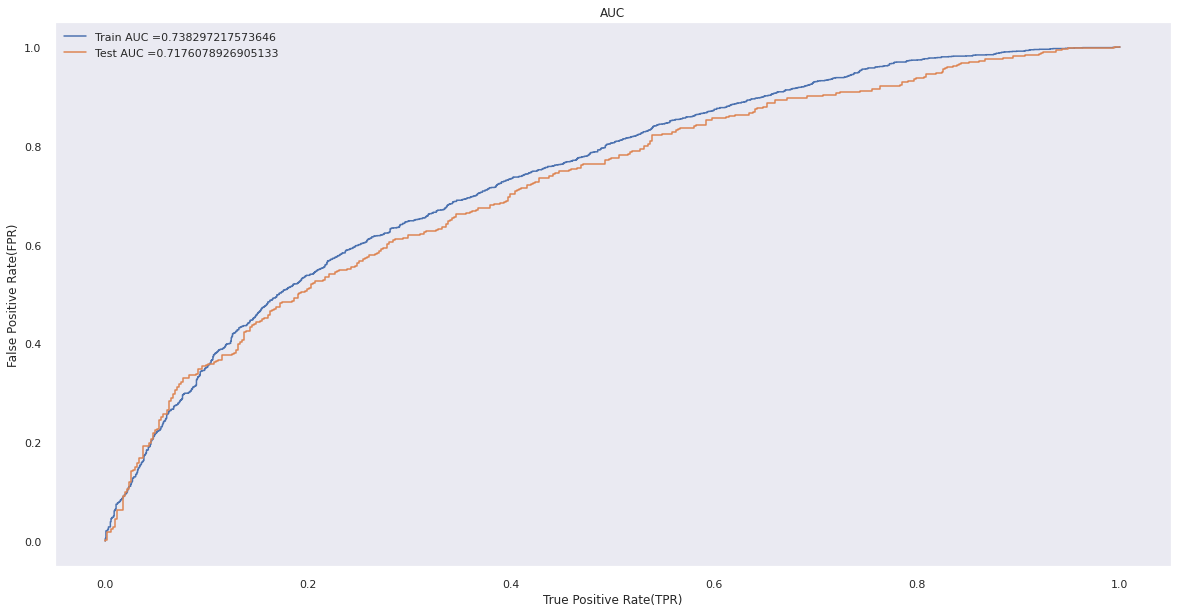

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', penalty='l2',alpha = 1.0,class_weight='balanced') #Multinominal Naive Bayes.
svm.fit(scaled_data_tr,y_train)

y_train_pred = svm.decision_function(scaled_data_tr)    
y_test_pred = svm.decision_function(scaled_data_te)

print(y_train)
print(y_train_pred)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(20,10))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")

cm = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(cm)

Precision = cm[0][0]/(cm[0][0]+cm[0][1])
Recall = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = 2*(Precision*Recall)/(Precision+Recall)

print("="*100)
print("F1 Score",f1_score)
print("Precision",Precision)
print("Recall",Recall)  

Train confusion matrix
[[1129  474]
 [ 741 1351]]
Test confusion matrix
[[479  33]
 [458 185]]
F1 Score 0.6611456176673568
Precision 0.935546875
Recall 0.5112059765208111


In [ ]:
y_pred = svm.predict(scaled_data_df2)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

**LogisticRegression with SGDClassifier**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from  imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import math

logis = SGDClassifier(class_weight='balanced')
parameters = {'loss' :['log'],'penalty' :["l1", "l2"],'alpha':[abs(math.log10(10**1)),abs(math.log10(10**2)),abs(math.log10(10**3)),abs(math.log10(10**4))\
                       ,abs(math.log10(10**5)),abs(math.log10(10**6)),abs(math.log10(10**7))\
                       ,abs(math.log10(10**8))]}

clf = GridSearchCV(logis, parameters, cv= 10, scoring='roc_auc')
grid_result = clf.fit(scaled_data_tr,y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.7243392176092405
Best Params:  {'alpha': 1.0, 'loss': 'log', 'penalty': 'l2'}


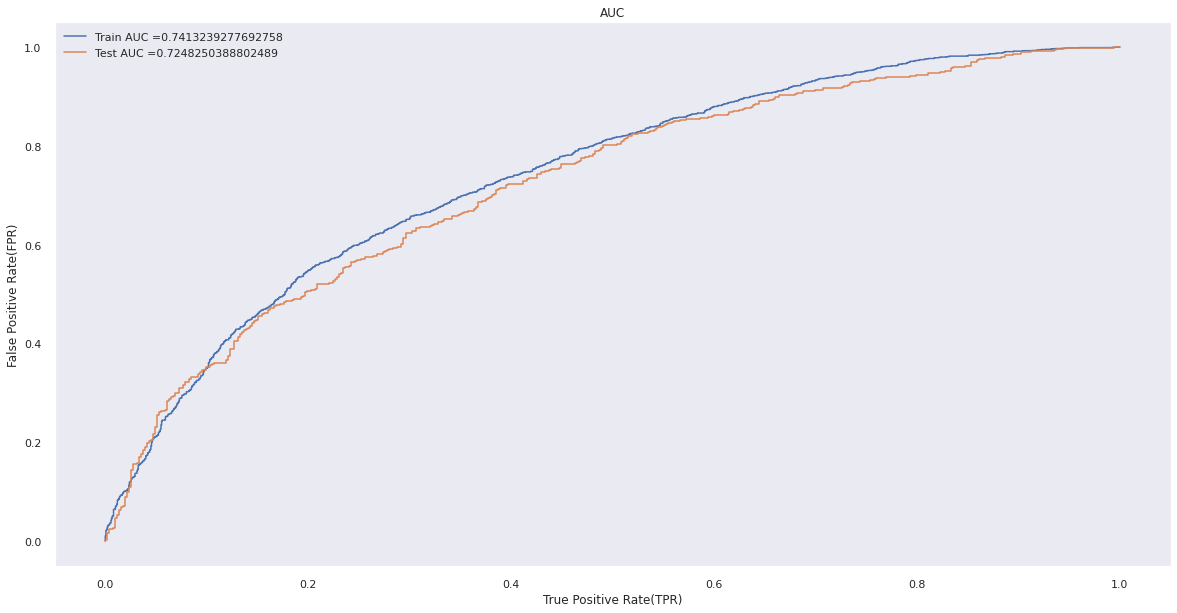

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

logis = SGDClassifier(loss='log', penalty='l2',alpha = 1.0,class_weight='balanced') 
logis.fit(scaled_data_tr,y_train)
y_pred = logis.predict(scaled_data_te)

y_train_pred = logis.decision_function(scaled_data_tr)    
y_test_pred = logis.decision_function(scaled_data_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(20,10))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")
cm = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(cm)

Precision = cm[0][0]/(cm[0][0]+cm[0][1])
Recall = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = 2*(Precision*Recall)/(Precision+Recall)

print("="*100)
print("F1 Score",f1_score)
print("Precision",Precision)
print("Recall",Recall)  

Train confusion matrix
[[1120  483]
 [ 716 1376]]
Test confusion matrix
[[475  37]
 [448 195]]
F1 Score 0.6620209059233451
Precision 0.927734375
Recall 0.514626218851571


**Hyper Parameter tuning for XGB**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [ ]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [ ]:
grid_search.fit(scaled_data_tr, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 11.0min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed: 21.6min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 29.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
        

In [ ]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [ ]:
from xgboost import XGBClassifier
params={
    'n_estimators':140,
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'gamma':0,
    'subsample':1,
    'colsample_bytree':1,
    'min_child_weight':1,
    'max_depth':5,
    'seed':42,
    }
clf = XGBClassifier(**params)
clf.fit(scaled_data_tr, y_train, \
        eval_set=[(scaled_data_tr, y_train), (scaled_data_te, y_test)], \
                  eval_metric='auc', early_stopping_rounds = 10)

[0]	validation_0-auc:0.748188	validation_1-auc:0.694877
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.770178	validation_1-auc:0.70176
[2]	validation_0-auc:0.780455	validation_1-auc:0.716332
[3]	validation_0-auc:0.787553	validation_1-auc:0.721753
[4]	validation_0-auc:0.793231	validation_1-auc:0.726695
[5]	validation_0-auc:0.798211	validation_1-auc:0.727964
[6]	validation_0-auc:0.802758	validation_1-auc:0.72934
[7]	validation_0-auc:0.813376	validation_1-auc:0.736905
[8]	validation_0-auc:0.822107	validation_1-auc:0.743032
[9]	validation_0-auc:0.826451	validation_1-auc:0.747477
[10]	validation_0-auc:0.832423	validation_1-auc:0.752658
[11]	validation_0-auc:0.835656	validation_1-auc:0.755638
[12]	validation_0-auc:0.840062	validation_1-auc:0.757986
[13]	validation_0-auc:0.846029	validation_1-auc:0.760161
[14]	validation_0-auc:0.848623	validation_1-auc:0.760915


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

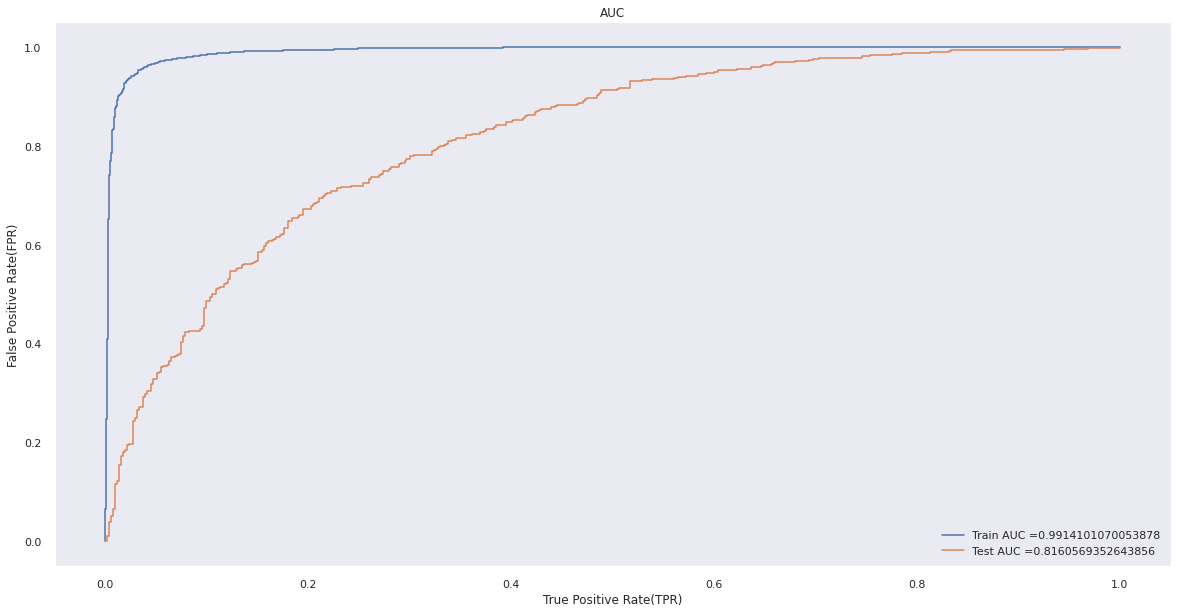

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs1 = clf.predict_proba(scaled_data_tr)
preds1 = probs1[:,1]
probs2 = clf.predict_proba(scaled_data_te)
preds2 = probs2[:,1]
train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, preds1)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, preds2)
#roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(20,10))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(preds1, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")

cm = confusion_matrix(y_test, predict(preds2, tr_thresholds, test_fpr, test_tpr))
print(cm)

Precision = cm[0][0]/(cm[0][0]+cm[0][1])
Recall = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = 2*(Precision*Recall)/(Precision+Recall)

print("="*100)
print("F1 Score",f1_score)
print("Precision",Precision)
print("Recall",Recall) 

Train confusion matrix
[[1536   67]
 [  78 2014]]
Test confusion matrix
[[306 206]
 [ 97 546]]
F1 Score 0.6688524590163935
Precision 0.59765625
Recall 0.7593052109181141


**AdaBoostClassifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
import pickle

model = AdaBoostClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [500]
#grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['learning_rate'] = [0.1]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.686585 using {'learning_rate': 0.1, 'n_estimators': 500}


In [ ]:
import pickle
pickle.dump(grid_result,open('/content/drive/My Drive/final_model.pkl','wb'))

In [ ]:
#you can load from disk
model = pickle.load(open("/content/drive/My Drive/final_model.pkl",'rb'))

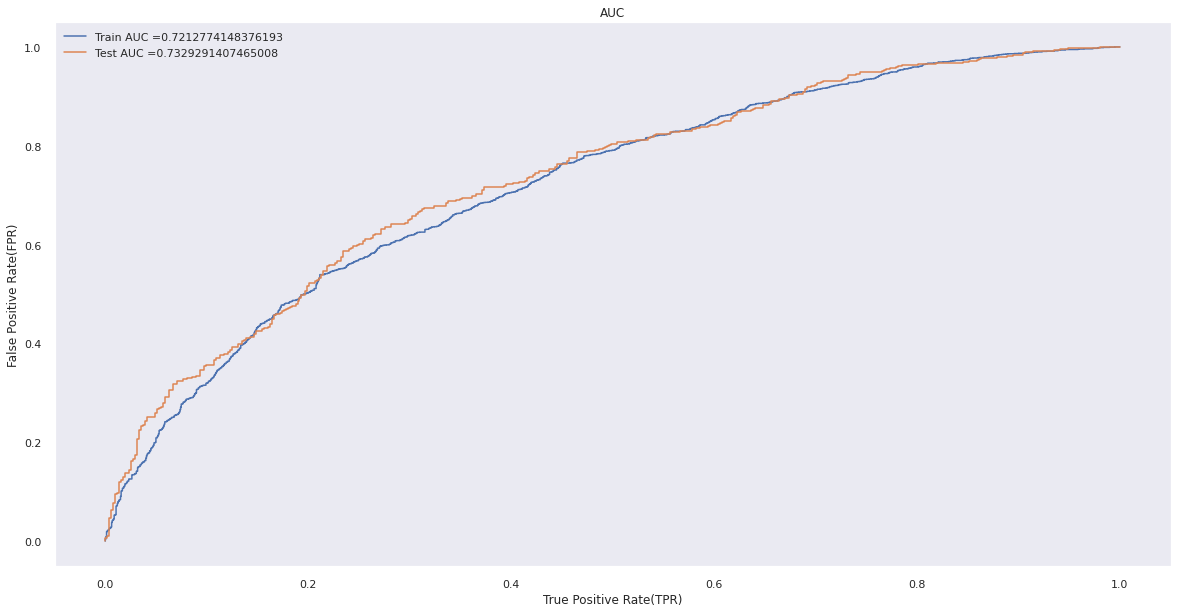

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs1 = grid_result.predict_proba(scaled_data_tr)
preds1 = probs1[:,1]
probs2 = grid_result.predict_proba(scaled_data_te)
preds2 = probs2[:,1]
train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, preds1)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, preds2)
#roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(20,10))

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(preds1, tr_thresholds, train_fpr, train_tpr)))
print("="*100)
print("Test confusion matrix")

cm = confusion_matrix(y_test, predict(preds2, tr_thresholds, test_fpr, test_tpr))
print(cm)

Precision = cm[0][0]/(cm[0][0]+cm[0][1])
Recall = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = 2*(Precision*Recall)/(Precision+Recall)

print("="*100)
print("F1 Score",f1_score)
print("Precision",Precision)
print("Recall",Recall) 

Train confusion matrix
[[1169  434]
 [ 844 1248]]
Test confusion matrix
[[478  34]
 [446 197]]
F1 Score 0.6657381615598886
Precision 0.93359375
Recall 0.5173160173160173


In [1]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Model-Name"," Train-AUC ","Test-AUC","F1-Score","Precision","Recall")
tb.add_row(["XGB", .991 , .816 , .668, .59, .759 ])
tb.add_row(["SGD Classifier with SVC", .738 , .718 , .662 , .931, .5134 ])
tb.add_row(["SGDClassifier  with Logisticregrssion", .741, .724, .662, .931, .513 ])
tb.add_row(["Ada Boost", .721, .732, 0.665, 0.93, .51 ])

print(tb.get_string(titles = "Happiness Prediction with different models "))

+---------------------------------------+-------------+----------+----------+-----------+--------+
|               Model-Name              |  Train-AUC  | Test-AUC | F1-Score | Precision | Recall |
+---------------------------------------+-------------+----------+----------+-----------+--------+
|                  XGB                  |    0.991    |  0.816   |  0.668   |    0.59   | 0.759  |
|        SGD Classifier with SVC        |    0.738    |  0.718   |  0.662   |   0.931   | 0.5134 |
| SGDClassifier  with Logisticregrssion |    0.741    |  0.724   |  0.662   |   0.931   | 0.513  |
|               Ada Boost               |    0.721    |  0.732   |  0.665   |    0.93   |  0.51  |
+---------------------------------------+-------------+----------+----------+-----------+--------+
